In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Building Classification using Deep Learning
## 1. Problem Statement

In this project, the objective is to classify buildings into five categories (A, B, C, D, S) based on images. The dataset contains images of buildings, each labeled with one of these five classes. Building classification is an important task in various fields, such as urban planning, architecture, and disaster management, where classifying buildings based on structural characteristics can help in assessing risk, monitoring development, and improving planning.

This notebook will implement a machine learning model, using a deep learning approach, to accurately classify buildings into these categories. We will explore the data, preprocess it, and train a neural network to perform this classification task.

The goal of this project is to classify different types of buildings based on their architectural features. The classification is based on images of buildings, and the types include Steel, Concrete, Masonry, Wooden Framed, and Steel with Panel Buildings.



## 2. Building Class: Material and Properties

| **Class Type** | **Building Material**      | **Other Properties**                                                                                                                                     |
|----------------|----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------|
| A (1)          | Steel Buildings             | Extensive presence of glass or reflective cover, rounded surfaces, exposed steel skeleton, complex frame geometry, presence of slabs, significant slenderness |
| B (2)          | Concrete                    | Exposed concrete, thick and regular structure skeleton, boxy aspect, smooth texture, persistent opening arrangement                                       |
| C (3)          | Masonry                     | Reinforced or Unreinforced, bricks exposed, low opening/wall ratio, no soft story or large openings in bottom part, presence of decorative patterns       |
| D (4)          | Wooden framed               | Wooden frame exposed, wooden bow windows, irregular opening structure, slanted roof, vivid colouring and painting outlines                                |
| S (5)          | Steel with panel buildings  | Typical for industrial or retail, max 2 floors (rows of openings), big and sparse lower level openings, non-slanted roof, no elaborate texture on the outside, panel by panel cover |

*Table : Building class: Material and Properties*


## 3. Data Exploration

Before we dive into building the classification model, it's essential to understand the dataset. This section will explore the images, their distribution among classes, and other relevant properties.


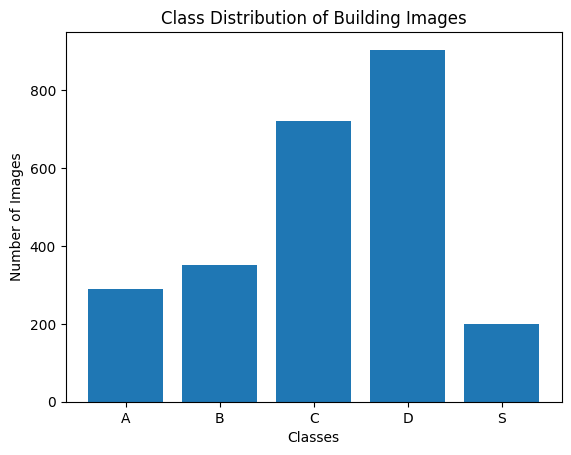

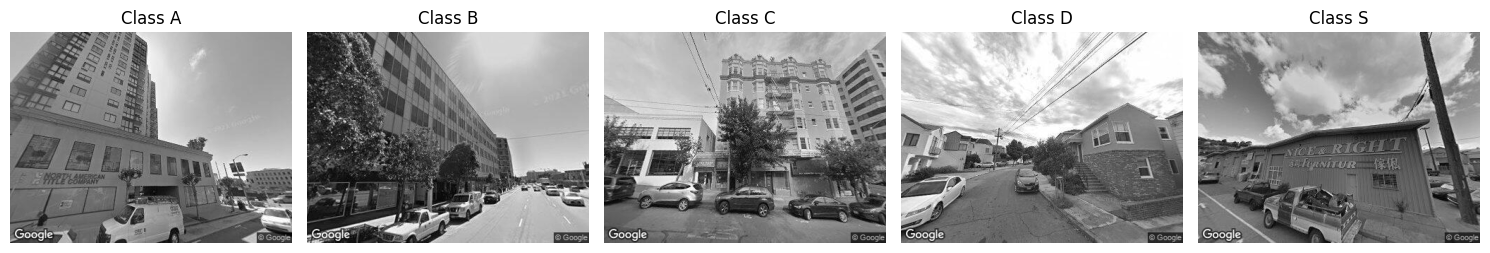

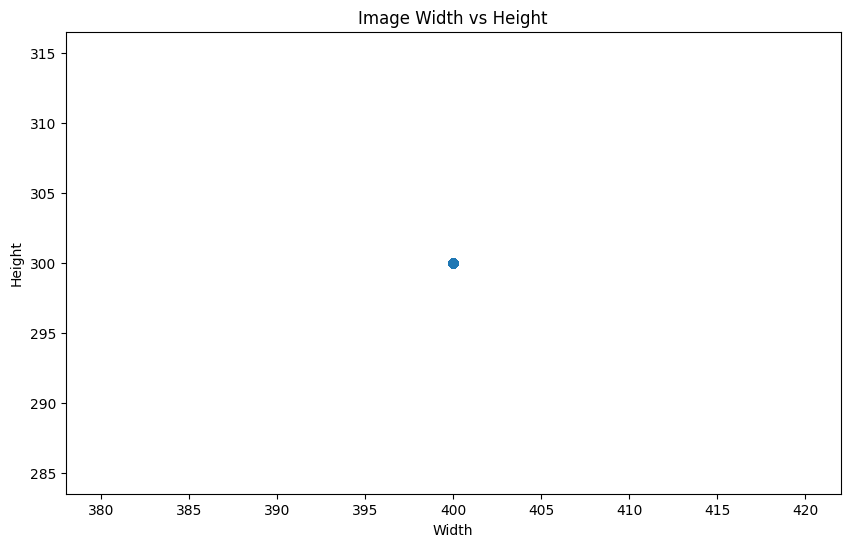

Image Attributes Summary:
{'Number of Images': 2466, 'Number of Channels': 3, 'Images per Class': {'A': 289, 'B': 352, 'C': 721, 'D': 904, 'S': 200}}


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Define the dataset path
dataset_path = '/kaggle/input/nwe-dataset3/Dataset/Train_Data'

# List of classes
classes = ['A', 'B', 'C', 'D', 'S']

# Function to get class distribution
def get_class_distribution(dataset_path):
    class_counts = {}
    for cls in classes:
        class_folder = os.path.join(dataset_path, cls)
        class_counts[cls] = len(os.listdir(class_folder))
    return class_counts

# Function to plot class distribution
def plot_class_distribution(class_distribution):
    plt.bar(class_distribution.keys(), class_distribution.values())
    plt.title('Class Distribution of Building Images')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.show()

# Function to display sample images
def display_sample_images(dataset_path):
    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
    for i, class_name in enumerate(classes):
        sample_image_path = os.path.join(dataset_path, class_name, os.listdir(os.path.join(dataset_path, class_name))[0])
        sample_image = Image.open(sample_image_path)
        
        axes[i].imshow(sample_image,cmap='gray')
        axes[i].set_title(f'Class {class_name}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Function to check image dimensions
def check_image_dimensions(dataset_path):
    image_sizes = []
    for class_name in classes:
        class_folder = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            with Image.open(img_path) as img:
                image_sizes.append(img.size)
    return image_sizes

# Function to summarize image attributes
def summarize_image_attributes(dataset_path):
    class_counts = get_class_distribution(dataset_path)
    num_images = sum(class_counts.values())
    
    num_channels = 3 
    image_summary = {
        'Number of Images': num_images,
        'Number of Channels': num_channels,
        'Images per Class': class_counts
    }
    return image_summary

# Main execution
class_distribution = get_class_distribution(dataset_path)
plot_class_distribution(class_distribution)

# Display sample images from each class
display_sample_images(dataset_path)

# Checking image dimensions
image_sizes = check_image_dimensions(dataset_path)

# Convert to dataframe for easier viewing
df_image_sizes = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

# Plotting the image dimensions
plt.figure(figsize=(10, 6))
plt.scatter(df_image_sizes['Width'], df_image_sizes['Height'], alpha=0.5)
plt.title('Image Width vs Height')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

# Image attributes summary
image_summary = summarize_image_attributes(dataset_path)
print("Image Attributes Summary:")
print(image_summary)


## 4. Summary of EDA Findings
- **Image Characteristics:**
  - Type: Grayscale (3 channels)
  - Dimensions: (300, 400)
- **Total Number of Images:** 2466
- **Images per Class:**
  - Class A: 289
  - Class B: 352
  - Class C: 721
  - Class D: 904
  - Class S: 200

### Analysis
The distribution of images across classes indicates a potential class imbalance, particularly with class D being more represented. This imbalance could lead to a biased model. Data augmentation strategies will be considered to enhance model performance across all classes.


# 2. Building EfficientNet Model
## 1. Importing Required Libraries 
This section imports the necessary libraries for data manipulation, model building, training, and evaluation.

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
from PIL import Image
import numpy as np
import optuna
from PIL import ImageOps
from skimage import exposure
from sklearn.model_selection import StratifiedKFold

## 2. Custom Dataset Class
The dataset class effectively manages the loading of images and labels while keeping track of class frequencies. This will be useful for applying weighted sampling during training to mitigate class imbalance.

In [4]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        #self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(os.listdir(root_dir)))}
        # Define your custom class-to-index mapping
        self.class_to_idx = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'S': 4}
        
        for cls in os.listdir(root_dir):
            cls_dir = os.path.join(root_dir, cls)
            if cls in self.class_to_idx:
                print(f"Class {cls} has {len(os.listdir(cls_dir))} images.")
                for img_name in os.listdir(cls_dir):
                    self.images.append(os.path.join(cls_dir, img_name))
                    self.labels.append(self.class_to_idx[cls])
#             print(f"Class {cls} has {len(os.listdir(cls_dir))} images.")
#             for img_name in os.listdir(cls_dir):
#                 self.images.append(os.path.join(cls_dir, img_name))
#                 self.labels.append(self.class_to_idx[cls])
        
        self.labels = np.array(self.labels)
        
        # Calculate class frequencies and class weights
        class_counts = np.bincount(self.labels)
        self.class_weights = torch.tensor(len(self.labels) / (len(class_counts) * class_counts), dtype=torch.float32)
        print("Class counts array: ", class_counts)
        print("Unique labels:", set(self.labels))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, label


## 3. Image Preprocessing Functions
The preprocessing functions enhance the image quality and variability through random transformations. These augmentations help improve model generalization by exposing it to various image conditions.

In [5]:
def contrast_stretching(img):
    """Perform contrast stretching on a grayscale image."""
    # Convert to grayscale
    grayscale_img = ImageOps.grayscale(img)
    
    # Get the pixel values as a numpy array
    np_img = np.array(grayscale_img)
    
    # Apply contrast stretching
    p2, p98 = np.percentile(np_img, (2, 98))
    stretched_img = exposure.rescale_intensity(np_img, in_range=(p2, p98))
    return Image.fromarray(np.clip(stretched_img, 0, 255).astype('uint8')).convert("RGB")

def get_data_transforms():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=5), # Small rotation
        transforms.ColorJitter(brightness=0.1, contrast=0.1), # Brightness and contrast adjustment
        transforms.Lambda(lambda img: ImageOps.equalize(img)), # Histogram equalization 
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)), # Apply Gaussian blur
        transforms.RandomCrop(size=(224, 224), padding=10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


## 4. Model Creation
In this section, the EfficientNet model is defined with added dropout and batch normalization layers.

Using EfficientNet, known for its efficiency and accuracy, is a good choice for this classification task. The dropout layer helps prevent overfitting.



In [6]:
# Create EfficientNet model with Batch Normalization and Dropout
def create_model():
    model = models.efficientnet_b0(weights=None)
    model.load_state_dict(torch.load('/kaggle/input/effnet/pytorch/default/1/efficientnet_b0_rwightman-7f5810bc.pth'))
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_features, 5),
        nn.BatchNorm1d(5)
    )
    return model


## 5. Loss Function Definition
This section implements the focal loss function.

Focal loss focuses more on hard-to-classify examples, which is beneficial in situations where classes are imbalanced. This can improve model performance on minority classes.





In [7]:
# Focal Loss Implementation
class FocalLoss(nn.Module):
    def __init__(self, gamma=1.0, reduction='mean', class_weights=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.register_buffer('class_weights', class_weights)

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss(reduction='none', weight=self.class_weights)(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss


## 6. Feature Visualization
This section visualizes the features extracted from the model using PCA and t-SNE.

Visualizing the extracted features can provide insights into the model’s learning and help identify how well different classes are separated in feature space.


In [8]:
def visualize_features(model, dataset, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, lbls in tqdm(DataLoader(dataset, batch_size=32, shuffle=False), desc="Extracting Features"):
            inputs = inputs.to(device)
            # Extract features before the classifier (use the penultimate layer)
            feature = model.features(inputs).cpu() # Extract from model.features
            features.append(feature.view(feature.size(0), -1)) # Flatten the features
            labels.append(lbls.cpu())

    features = torch.cat(features).numpy()
    labels = torch.cat(labels).numpy()

    # PCA 2D Visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette="deep")
    plt.title('PCA of Features')
    plt.show()
    
    # PCA 3D Visualization
    pca_3d = PCA(n_components=3)
    pca_result_3d = pca_3d.fit_transform(features)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(pca_result_3d[:, 0], pca_result_3d[:, 1], pca_result_3d[:, 2], c=labels, cmap='viridis')
    ax.set_title('PCA of Features in 3D')
    plt.colorbar(scatter)
    plt.show()
    
    pca = PCA(n_components=1500)  # Reduce features to 500 dimensions before t-SNE
    reduced_features = pca.fit_transform(features)
    
    
    # t-SNE Visualization
    tsne = TSNE(n_components=2, perplexity=20, n_iter=250)
    tsne_result = tsne.fit_transform(reduced_features)
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="deep")
    plt.title('t-SNE of Features')
    plt.show()
    
    
    # t-SNE 3D Visualization
    tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=300)
    tsne_result_3d = tsne_3d.fit_transform(reduced_features)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(tsne_result_3d[:, 0], tsne_result_3d[:, 1], tsne_result_3d[:, 2], c=labels, cmap='viridis')
    ax.set_title('t-SNE of Features in 3D')
    plt.colorbar(scatter)
    plt.show()


## 7. Model Training with K-Fold Cross-Validation
This section defines the training process, incorporating k-fold cross-validation for robust model evaluation.

The use of k-fold cross-validation ensures that the model's performance is evaluated across different subsets of the dataset, enhancing the reliability of the results.



In [9]:
# Train the model with k-fold cross-validation
def train_model(model, dataset, num_epochs=20, lr=1e-4, batch_size=32, gamma=1.0, patience=5):
    best_accuracy = 0.0
    best_model_weights = None
    early_stopping_counter = 0  # Counter for early stopping

    kf = KFold(n_splits=5)

    for fold, (train_indices, val_indices) in enumerate(kf.split(np.arange(len(dataset)))):        
        print(f"Fold {fold + 1}/{kf.n_splits}")


        # Sampler for class imbalance
        class_weights = dataset.class_weights[dataset.labels[train_indices]]
        sampler = WeightedRandomSampler(class_weights, num_samples=len(train_indices), replacement=True)
        
        skf = StratifiedKFold(n_splits=5, shuffle=True)

        for train_index, val_index in skf.split(np.zeros(len(dataset)), dataset.labels):
            train_subset = torch.utils.data.Subset(dataset, train_index)
            val_subset = torch.utils.data.Subset(dataset, val_index)

            # Define WeightedRandomSampler here to handle class imbalance
            train_loader = DataLoader(train_subset, batch_size=batch_size, sampler=sampler)
            val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)


        # Criterion and optimizer
        criterion = FocalLoss(gamma=gamma, class_weights=dataset.class_weights).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=lr)
        
        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

        # Tracking for loss and accuracy
        train_loss_values = []
        val_loss_values = []
        val_accuracy_values = []

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            running_corrects = 0
            total = 0

            progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}", leave=False)
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = running_corrects.double() / total

            # Store training loss and accuracy
            train_loss_values.append(epoch_loss)

            print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

            # Validation Phase
            model.eval()
            val_running_loss = 0.0
            val_running_corrects = 0
            val_total = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    val_running_loss += loss.item() * inputs.size(0)
                    _, val_preds = torch.max(outputs, 1)
                    val_running_corrects += torch.sum(val_preds == labels.data)
                    val_total += labels.size(0)

            val_epoch_loss = val_running_loss / val_total
            val_epoch_acc = val_running_corrects.double() / val_total
            val_loss_values.append(val_epoch_loss)
            val_accuracy_values.append(val_epoch_acc)

            # Scheduler step
            scheduler.step(val_epoch_loss)

            print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.4f}")

            # Early stopping check
            if val_epoch_acc > best_accuracy:
                best_accuracy = val_epoch_acc
                best_model_weights = model.state_dict()
                early_stopping_counter = 0  # Reset counter if there is improvement
            else:
                early_stopping_counter += 1  # Increment counter for no improvement

            # Check if early stopping should be applied
            if early_stopping_counter >= patience:
                print("Early stopping triggered!")
                break  # Exit the training loop

        print(f"Best Validation Accuracy for Fold {fold + 1}: {best_accuracy:.4f}")
        

    model.load_state_dict(best_model_weights)
    return model, train_loss_values, val_loss_values, val_accuracy_values

## 8. Evaluation
This section evaluates the model on the validation set, providing insights through classification reports and confusion matrices.

The evaluation metrics provide a detailed overview of the model's performance across different classes, highlighting areas for improvement.



In [10]:
def evaluate_model(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # Generate classification report
    print("Classification Report:")
    # Generate classification report
    classes = ['A', 'B', 'C', 'D', 'S']
    print(classification_report(all_labels, all_preds, target_names=list(dataset.class_to_idx.keys())))
    
    # for debug purpose
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(dataset.class_to_idx.keys()), yticklabels=list(dataset.class_to_idx.keys()))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # for debug purpose
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


## 9. Hyperparameter Tuning with Optuna
This section uses Optuna for hyperparameter optimization to improve model performance further.

Optuna helps automate the search for the best hyperparameters, potentially leading to better model performance with minimal manual tuning.

In [11]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [12]:
# Optuna optimization
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    num_epochs = trial.suggest_int('num_epochs', 10, 30)
    gamma = trial.suggest_float('gamma', 0.0, 3.0)

    model = create_model().to(device)
    dataset = CustomDataset('/kaggle/input/nwe-dataset3/Dataset/Train_Data', transform=get_data_transforms())
    
    trained_model, train_loss, val_loss, val_acc = train_model(model, dataset, num_epochs=num_epochs, lr=lr, gamma=gamma)
    
    return max(val_acc)

# Running Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Printing best trial
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params:")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
#Visualize the optimization process
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

[I 2024-10-11 09:26:03,097] A new study created in memory with name: no-name-9558e504-eeed-4c3a-ba7c-d98aed0dab6c
/tmp/ipykernel_30/2151746949.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/tmp/ipykernel_30/3689761081.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via t

Class B has 352 images.
Class S has 200 images.
Class A has 289 images.
Class C has 721 images.
Class D has 904 images.
Class counts array:  [289 352 721 904 200]
Unique labels: {0, 1, 2, 3, 4}
Fold 1/5


[W 2024-10-11 09:26:12,868] Trial 0 failed with parameters: {'lr': 0.0024305423499734456, 'num_epochs': 16, 'gamma': 1.3431550194743045} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_30/2151746949.py", line 10, in objective
    trained_model, train_loss, val_loss, val_acc = train_model(model, dataset, num_epochs=num_epochs, lr=lr, gamma=gamma)
  File "/tmp/ipykernel_30/884554410.py", line 53, in train_model
    loss.backward()
  File "/opt/conda/lib/python3.10/site-packages/torch/_tensor.py", line 521, in backward
    torch.autograd.backward(
  File "/opt/conda/lib/python3.10/site-packages/torch/autograd/__init__.py", line 289, in backward
    _engine_run_backward(
  File "/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py", line 768, in _engine_run_backward
    return Variable

KeyboardInterrupt: 

## 10. Train model with best param obtained by Optuna

In [13]:
# Retrieve best parameters

lr = 0.00035538741615831156  # Replace with best_params['lr'] if uncommented
num_epochs = 22 # Replace with best_params['num_epochs'] if uncommented
gamma = 1.0871812868920547 # Replace with best_params['gamma'] if uncommented

# Create a new model instance
model = create_model().to(device)

# Prepare the dataset again
dataset = CustomDataset(root_dir='/kaggle/input/nwe-dataset3/Dataset/Train_Data', transform=get_data_transforms())


# Retrain the model
trained_model, train_loss, val_loss, val_acc  = train_model(model, dataset, num_epochs=num_epochs, lr=lr, gamma=gamma)

/tmp/ipykernel_30/3689761081.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/effnet/pytorch/default/1/efficientnet_b0_rwi

Class B has 352 images.
Class S has 200 images.
Class A has 289 images.
Class C has 721 images.
Class D has 904 images.
Class counts array:  [289 352 721 904 200]
Unique labels: {0, 1, 2, 3, 4}
Fold 1/5


Training Loss: 1.4385, Training Accuracy: 0.3682
Validation Loss: 1.0108, Validation Accuracy: 0.4280


Training Loss: 1.0369, Training Accuracy: 0.4894
Validation Loss: 0.9829, Validation Accuracy: 0.3834


Training Loss: 0.9191, Training Accuracy: 0.5446
Validation Loss: 0.9655, Validation Accuracy: 0.4381


Training Loss: 0.7628, Training Accuracy: 0.6237
Validation Loss: 0.9114, Validation Accuracy: 0.4584


Training Loss: 0.6869, Training Accuracy: 0.6511
Validation Loss: 0.9072, Validation Accuracy: 0.5193


Training Loss: 0.6113, Training Accuracy: 0.6815
Validation Loss: 0.9157, Validation Accuracy: 0.5071


Training Loss: 0.5330, Training Accuracy: 0.7155
Validation Loss: 0.8906, Validation Accuracy: 0.5213


Training Loss: 0.4714, Training Accuracy: 0.7495
Validation Loss: 0.8275, Validation Accuracy: 0.5477


Training Loss: 0.4324, Training Accuracy: 0.7693
Validation Loss: 0.9038, Validation Accuracy: 0.5274


Training Loss: 0.3988, Training Accuracy: 0.7911
Validation Loss: 0.8990, Validation Accuracy: 0.5558


Training Loss: 0.3682, Training Accuracy: 0.7926
Validation Loss: 0.8295, Validation Accuracy: 0.5497


Training Loss: 0.3194, Training Accuracy: 0.8124
Validation Loss: 0.8955, Validation Accuracy: 0.5598


Training Loss: 0.3200, Training Accuracy: 0.8220
Validation Loss: 0.8972, Validation Accuracy: 0.5335


Training Loss: 0.2781, Training Accuracy: 0.8453
Validation Loss: 0.8684, Validation Accuracy: 0.5598


Training Loss: 0.2773, Training Accuracy: 0.8509
Validation Loss: 0.8654, Validation Accuracy: 0.5903


Training Loss: 0.2868, Training Accuracy: 0.8413
Validation Loss: 0.8572, Validation Accuracy: 0.5842


Training Loss: 0.3018, Training Accuracy: 0.8519
Validation Loss: 0.8673, Validation Accuracy: 0.5761


Training Loss: 0.2655, Training Accuracy: 0.8524
Validation Loss: 0.8770, Validation Accuracy: 0.5963


Training Loss: 0.2636, Training Accuracy: 0.8504
Validation Loss: 0.8354, Validation Accuracy: 0.6045


Training Loss: 0.2655, Training Accuracy: 0.8565
Validation Loss: 0.8669, Validation Accuracy: 0.5761


Training Loss: 0.2564, Training Accuracy: 0.8504
Validation Loss: 0.8558, Validation Accuracy: 0.5538


Training Loss: 0.2710, Training Accuracy: 0.8611
Validation Loss: 0.8372, Validation Accuracy: 0.5822
Best Validation Accuracy for Fold 1: 0.6045
Fold 2/5


Training Loss: 0.4610, Training Accuracy: 0.7856
Validation Loss: 0.4037, Validation Accuracy: 0.7566


Training Loss: 0.4207, Training Accuracy: 0.7968
Validation Loss: 0.4616, Validation Accuracy: 0.7525


Training Loss: 0.3569, Training Accuracy: 0.8191
Validation Loss: 0.4703, Validation Accuracy: 0.7140


Training Loss: 0.3090, Training Accuracy: 0.8322
Validation Loss: 0.4832, Validation Accuracy: 0.7424


Training Loss: 0.2863, Training Accuracy: 0.8566
Validation Loss: 0.4912, Validation Accuracy: 0.7424


Training Loss: 0.2649, Training Accuracy: 0.8652
Validation Loss: 0.4715, Validation Accuracy: 0.7586


Training Loss: 0.2459, Training Accuracy: 0.8611
Validation Loss: 0.4682, Validation Accuracy: 0.7221


Training Loss: 0.2240, Training Accuracy: 0.8829
Validation Loss: 0.4650, Validation Accuracy: 0.7363


Training Loss: 0.2224, Training Accuracy: 0.8910
Validation Loss: 0.4299, Validation Accuracy: 0.7505


Training Loss: 0.2256, Training Accuracy: 0.8849
Validation Loss: 0.4216, Validation Accuracy: 0.7525


Training Loss: 0.2202, Training Accuracy: 0.8870
Validation Loss: 0.4352, Validation Accuracy: 0.7525
Early stopping triggered!
Best Validation Accuracy for Fold 2: 0.7586
Fold 3/5


Training Loss: 0.3545, Training Accuracy: 0.8236
Validation Loss: 0.2447, Validation Accuracy: 0.8093


Training Loss: 0.3298, Training Accuracy: 0.8358
Validation Loss: 0.2851, Validation Accuracy: 0.8073


Training Loss: 0.2744, Training Accuracy: 0.8596
Validation Loss: 0.2697, Validation Accuracy: 0.8357


Training Loss: 0.2513, Training Accuracy: 0.8632
Validation Loss: 0.2606, Validation Accuracy: 0.8235


Training Loss: 0.2211, Training Accuracy: 0.8910
Validation Loss: 0.2949, Validation Accuracy: 0.8114


Training Loss: 0.2137, Training Accuracy: 0.8839
Validation Loss: 0.2503, Validation Accuracy: 0.8256


Training Loss: 0.1771, Training Accuracy: 0.8971
Validation Loss: 0.2563, Validation Accuracy: 0.8418


Training Loss: 0.1890, Training Accuracy: 0.9012
Validation Loss: 0.2498, Validation Accuracy: 0.8499


Training Loss: 0.1749, Training Accuracy: 0.9027
Validation Loss: 0.2603, Validation Accuracy: 0.8276


Training Loss: 0.1723, Training Accuracy: 0.9078
Validation Loss: 0.2409, Validation Accuracy: 0.8418


Training Loss: 0.1709, Training Accuracy: 0.9133
Validation Loss: 0.2459, Validation Accuracy: 0.8215


Training Loss: 0.1800, Training Accuracy: 0.9098
Validation Loss: 0.2456, Validation Accuracy: 0.8560


Training Loss: 0.1699, Training Accuracy: 0.9199
Validation Loss: 0.2547, Validation Accuracy: 0.8377


Training Loss: 0.1634, Training Accuracy: 0.9164
Validation Loss: 0.2540, Validation Accuracy: 0.8357


Training Loss: 0.1605, Training Accuracy: 0.9214
Validation Loss: 0.2342, Validation Accuracy: 0.8398


Training Loss: 0.1627, Training Accuracy: 0.9240
Validation Loss: 0.2549, Validation Accuracy: 0.8540


Training Loss: 0.1712, Training Accuracy: 0.9108
Validation Loss: 0.2486, Validation Accuracy: 0.8296
Early stopping triggered!
Best Validation Accuracy for Fold 3: 0.8560
Fold 4/5


Training Loss: 0.2448, Training Accuracy: 0.8637
Validation Loss: 0.1901, Validation Accuracy: 0.8235
Early stopping triggered!
Best Validation Accuracy for Fold 4: 0.8560
Fold 5/5


Training Loss: 0.2568, Training Accuracy: 0.8657
Validation Loss: 0.1443, Validation Accuracy: 0.8905


Training Loss: 0.2143, Training Accuracy: 0.8743
Validation Loss: 0.1412, Validation Accuracy: 0.8925


Training Loss: 0.1938, Training Accuracy: 0.8931
Validation Loss: 0.1690, Validation Accuracy: 0.8824


Training Loss: 0.1855, Training Accuracy: 0.8961
Validation Loss: 0.1799, Validation Accuracy: 0.8722


Training Loss: 0.1808, Training Accuracy: 0.8946
Validation Loss: 0.2006, Validation Accuracy: 0.8438


Training Loss: 0.1982, Training Accuracy: 0.8865
Validation Loss: 0.2485, Validation Accuracy: 0.8235


Training Loss: 0.1657, Training Accuracy: 0.9067
Validation Loss: 0.1656, Validation Accuracy: 0.8641
Early stopping triggered!
Best Validation Accuracy for Fold 5: 0.8925


Class B has 10 images.
Class S has 10 images.
Class A has 10 images.
Class C has 10 images.
Class D has 10 images.
Class counts array:  [10 10 10 10 10]
Unique labels: {0, 1, 2, 3, 4}
Test Accuracy: 0.4400
Classification Report:
              precision    recall  f1-score   support

           A       0.62      1.00      0.77        10
           B       0.80      0.40      0.53        10
           C       0.27      0.40      0.32        10
           D       0.60      0.30      0.40        10
           S       0.11      0.10      0.11        10

    accuracy                           0.44        50
   macro avg       0.48      0.44      0.43        50
weighted avg       0.48      0.44      0.43        50

              precision    recall  f1-score   support

           A       0.62      1.00      0.77        10
           B       0.80      0.40      0.53        10
           C       0.27      0.40      0.32        10
           D       0.60      0.30      0.40        10
           

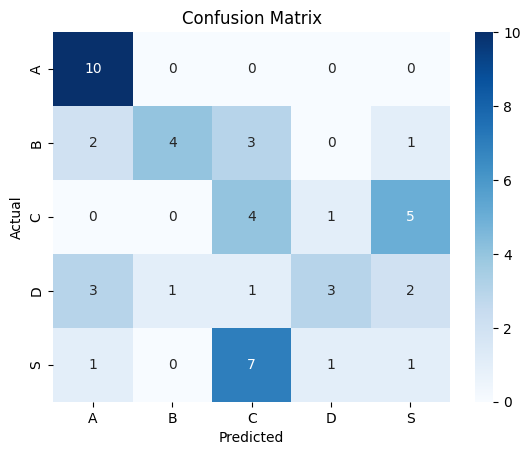

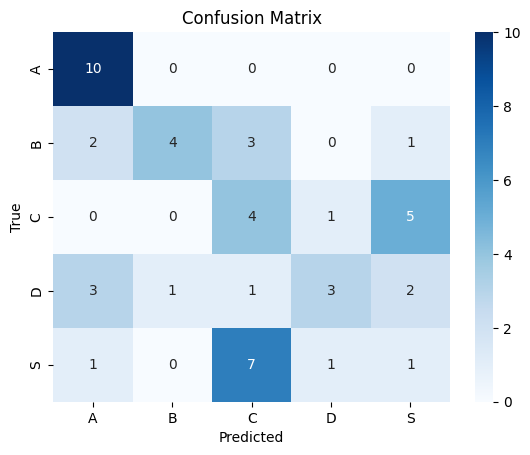

In [16]:
# Evaluation

# Define only the necessary transformations for evaluation
def get_evaluation_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to the input size of the model
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
    ])

# Load the test dataset
test_dataset = CustomDataset(root_dir='/kaggle/input/nwe-dataset3/Dataset/Test_Data', transform=get_evaluation_transforms())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the trained model on the test dataset
evaluate_model(trained_model, test_loader, device)

### Analysis of Results
The model achieved a test accuracy of 44%, indicating room for improvement.

- Class A performed the best, with a high recall of 90%, suggesting that the model is quite effective at identifying this class.
- Class C and Class S, however, showed lower precision and recall values, indicating that the model struggles to classify these classes correctly.
- Class D also exhibited a recall of only 30%, suggesting a significant challenge in accurately predicting this category.

### Next Steps
Given the current performance, the following actions could be beneficial:

- Data Augmentation: Further augment the dataset to help improve generalization.
- Model Fine-tuning: Experiment with different learning rates, batch sizes, or model architectures.
- Collecting More Data: If possible, gather more labeled data, particularly for the underperforming classes.


Extracting Features: 100%|██████████| 78/78 [01:43<00:00,  1.32s/it]


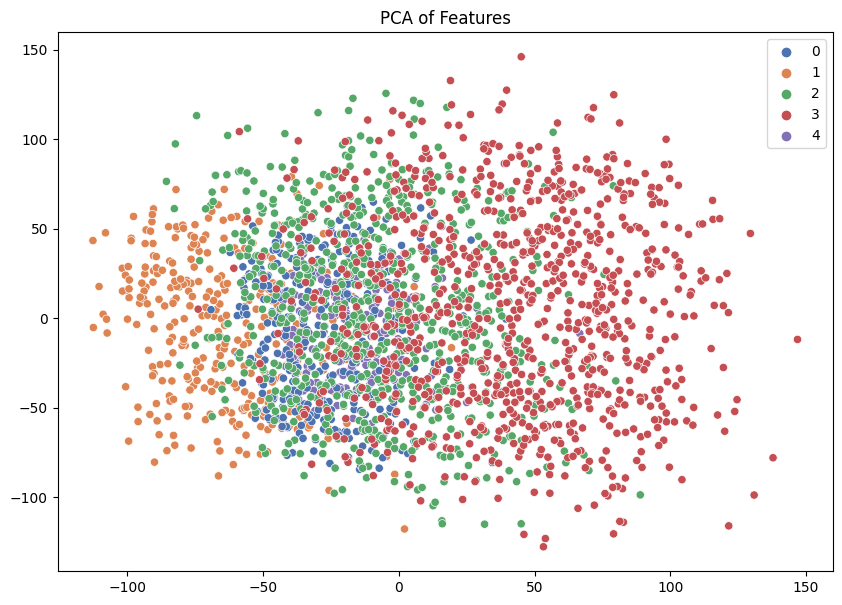

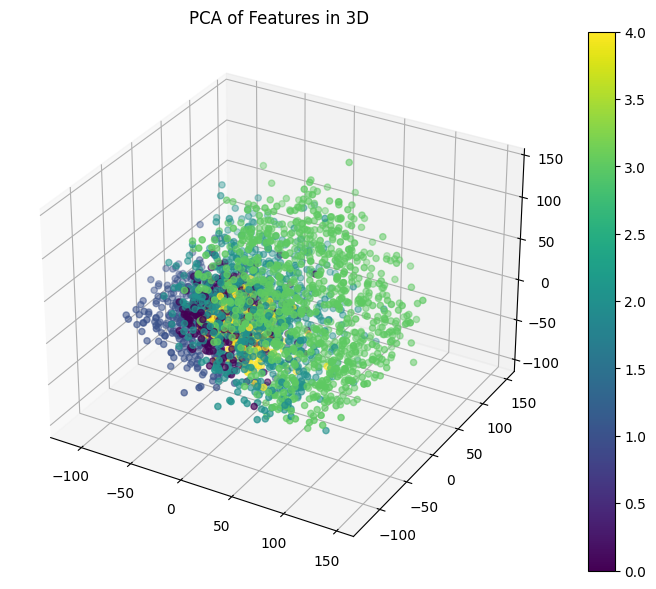

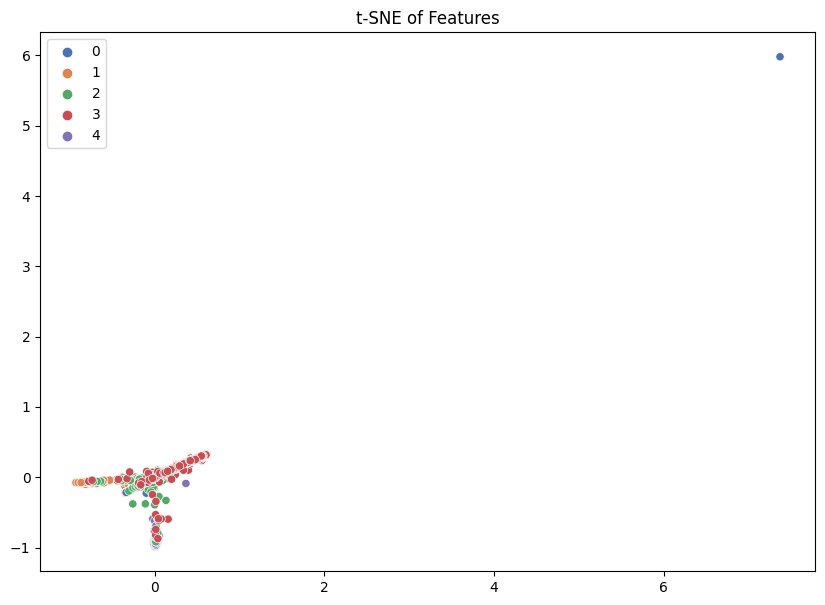

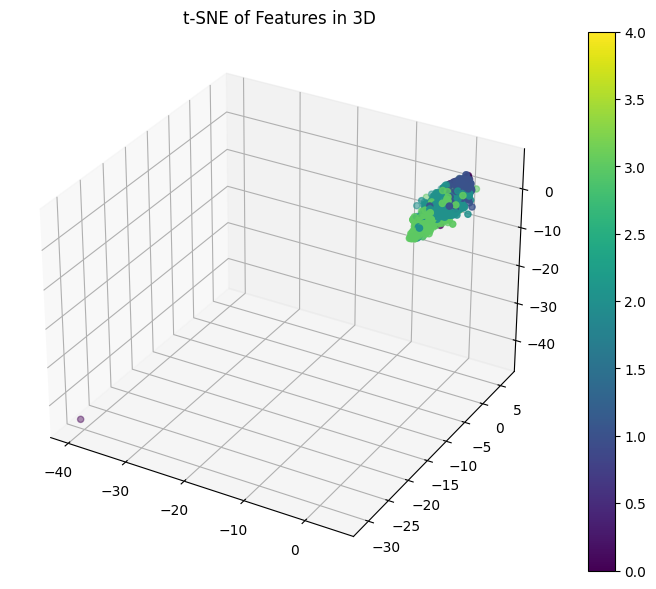

In [17]:
visualize_features(model, dataset, device)

### Presentation and Interpretation of PCA and t-SNE Results

#### PCA Visualization
PCA revealed that the classes are stacked on different layers, with **Class 3** exhibiting the maximum spread, indicating high variability. As we move to lower layers, the classes appear more compact, suggesting similarities in features.

#### t-SNE Visualization
The t-SNE visualization displayed a diagonal distribution of points, with **Class 3** occupying a significant portion of the line. **Class 1** was located at the opposite end, indicating that it is relatively distinct from Class 3. This suggests that while some classes can be easily distinguished, others may have overlapping features.

#### Insights
- The spread of **Class 3** indicates a diverse feature set.
- The overlap in feature space among classes may explain the model's performance limitations.

#### Next Steps
To enhance model performance, further analysis of the overlapping features and additional data preprocessing could be beneficial.


## 11. Save the Model

In [18]:
# Save the trained model's state_dict (weights)
torch.save(trained_model.state_dict(), 'building_classification_model.pth')

# Save the entire model (architecture + weights)
torch.save(trained_model, 'building_classification_full_model.pth')

## 12. Prediction

### 1. Using Trained Model

In [19]:
from PIL import Image
import torch
import torch.nn.functional as F

def predict_image(model, image_path, device, transform, class_to_idx):
    # Load the image
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image: {e}")
        return None, None
    
    # Apply transformations (same as the evaluation transformations)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move the image to the same device as the model
    image = image.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    with torch.no_grad():  # Disable gradient calculation for inference
        # Forward pass through the model
        outputs = model(image)
        
        # Apply softmax to get probabilities
        probabilities = F.softmax(outputs, dim=1)
        
        # Get the predicted class (index of the max probability)
        predicted_class_idx = probabilities.argmax(dim=1).item()
        
        # Map the predicted index back to the class label
        idx_to_class = {v: k for k, v in class_to_idx.items()}
        predicted_class = idx_to_class[predicted_class_idx]
        
        # Get the probability of the predicted class
        predicted_prob = probabilities[0, predicted_class_idx].item()

        return predicted_class, predicted_prob


Predicted Class: A, Probability: 0.4022


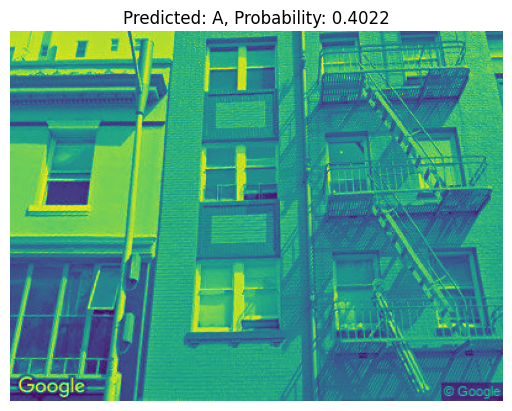

In [20]:
# Define the evaluation transformations (same as before)
transform = get_evaluation_transforms()

# Path to the image you want to predict
image_path = '/kaggle/input/nwe-dataset3/Dataset/Test_Data/A/10_A.jpg'

# Predict the class of the image
predicted_class, predicted_prob = predict_image(trained_model, image_path, device, transform, test_dataset.class_to_idx)

print(f'Predicted Class: {predicted_class}, Probability: {predicted_prob:.4f}')

# Visualize Prediction
def visualize_prediction(image_path, predicted_class, predicted_prob):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}, Probability: {predicted_prob:.4f}')
    plt.axis('off')
    plt.show()

visualize_prediction(image_path, predicted_class, predicted_prob)


### 2. Using Saved Model

In [21]:
def load_model(model_path, device, is_full_model=False):
    # If You Saved the Full Model:
    if is_full_model:
        model = torch.load(model_path)
        model = model.to(device)
    # If You Saved the weights:
    else:
        model = create_model().to(device)
        model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [22]:
# Load the model (state_dict or full model)
model = load_model('building_classification_model.pth', device, is_full_model=False)


/tmp/ipykernel_30/3689761081.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/effnet/pytorch/default/1/efficientnet_b0_rwi

Use the Saved Model for Prediction

Predicted Class: A, Probability: 0.4022


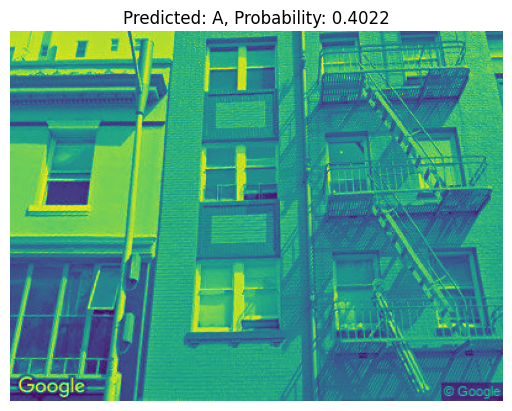

In [23]:
transform = get_evaluation_transforms()

# Path to the image you want to predict
image_path = '/kaggle/input/nwe-dataset3/Dataset/Test_Data/A/10_A.jpg'

# Predict the class of the image using the loaded model
predicted_class, predicted_prob = predict_image(model, image_path, device, transform, test_dataset.class_to_idx)

# Make Prediction
predicted_class, predicted_prob = predict_image(model, image_path, device, transform, test_dataset.class_to_idx)
print(f'Predicted Class: {predicted_class}, Probability: {predicted_prob:.4f}')


def visualize_prediction(image_path, predicted_class, predicted_prob):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}, Probability: {predicted_prob:.4f}')
    plt.axis('off')
    plt.show()

visualize_prediction(image_path, predicted_class, predicted_prob)

# 3. Feature Extraction and PCA

In [24]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC  # Example classifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from tqdm import tqdm


## 1. Feature Extraction

In [25]:

# # Extract and store features for later classification
# def extract_features(model, dataset, device):
#     model.eval()
#     features = []
#     labels = []

#     with torch.no_grad():
#         for inputs, lbls in tqdm(DataLoader(dataset, batch_size=32, shuffle=False), desc="Extracting Features"):
#             inputs = inputs.to(device)
#             # Extract features before the classifier (use the penultimate layer)
#             feature = model.features(inputs).cpu()  # Extract from model.features
#             features.append(feature.view(feature.size(0), -1))  # Flatten the features
#             labels.append(lbls.cpu())

#     features = torch.cat(features).numpy()  # Convert to NumPy array
#     labels = torch.cat(labels).numpy()  # Convert to NumPy array
#     return features, labels

def extract_and_save_features(model, dataset, device, file_path='features.npz'):
    model.eval()
    features, labels = [], []
    
    with torch.no_grad():
        for inputs, lbls in DataLoader(dataset, batch_size=32, shuffle=False):
            inputs = inputs.to(device)
            feature = model.features(inputs).cpu()
            features.append(feature.view(feature.size(0), -1))
            labels.append(lbls.cpu())

    features = torch.cat(features).numpy()
    labels = torch.cat(labels).numpy()

    # Save features and labels
    np.savez(file_path, features=features, labels=labels)
    print(f"Features saved to {file_path}")
    
    return features, labels

# Call the function using trained model
features, labels = extract_and_save_features(trained_model, dataset, device)



# Extract features using saved model
features2, labels2 = extract_and_save_features(model, dataset, device)



Features saved to features.npz
Features saved to features.npz


In [26]:
print(features.shape, labels.shape)  # Verify feature dimensions
print(features[0], labels[0])

(2466, 62720) (2466,)
[-0.27097592 -0.27766645 -0.2784033  ... -0.16068688 -0.0251139
 -0.00858652] 1


In [27]:
print(features2.shape, labels2.shape)  # Verify feature dimensions with features and labels
print(features2[0], labels2[0])

(2466, 62720) (2466,)
[-0.27067575 -0.23135892 -0.1965722  ... -0.26098898 -0.08086132
 -0.01719168] 1


## 2. PCA Analysis

### Cumulative Variance by PCA Components

In [37]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# pca = PCA()
# pca.fit(features)  # features is your data matrix

# # Plot the cumulative explained variance
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
#          np.cumsum(pca.explained_variance_ratio_), marker='o')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Explained Variance by Components')
# plt.grid()
# plt.axhline(y=0.95, color='r', linestyle='--')  # Optional 95% threshold line
# plt.axvline(x=1000, color='g', linestyle='--')  # Your choice
# plt.show()


from sklearn.decomposition import PCA
import joblib
import numpy as np

#def fit_and_save_pca(features, n_components=0.95, file_path='pca_model.pkl'):
def fit_and_save_pca(features, n_components=0.95):
    # PCA fitting, retain 95% variance
    pca = PCA(n_components=n_components)
    pca.fit(features)
    
    # Save PCA model
    joblib.dump(pca, file_path)
    print(f"PCA model saved.")
    
    return pca

#fit_and_save_pca()
# # Fit PCA on the features
# pca = PCA()
# pca.fit(features)

# # Calculate the cumulative explained variance
# cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# # Find the number of components required to explain 95% variance
# n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1  # Adding 1 because index starts at 0
# print(f"Number of components required to explain 95% of the variance: {n_components_95}")

# # Plot the cumulative variance with the 95% line
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), cumulative_variance, marker='o')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Explained Variance by Components')
# plt.grid()
# plt.axhline(y=0.95, color='r', linestyle='--')  # 95% variance threshold
# plt.axvline(x=n_components_95, color='g', linestyle='--')  # Line at the required number of components
# plt.show()

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# General PCA and Data Splitting Function
def prepare_data_with_pca(features, labels, test_size=0.2, random_state=42):
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=random_state, stratify=labels)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Perform PCA
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    return X_train_pca, X_test_pca, y_train, y_test


In [41]:
from sklearn.preprocessing import StandardScaler

X_train_pca, X_test_pca, y_train, y_test = prepare_data_with_pca(features, labels)

In [43]:
X_train_pca.shape

(1972, 1505)

In [45]:
y_train

array([1, 4, 0, ..., 2, 3, 1])

In [29]:
def load_pca_model(file_path='pca_model.pkl'):
    # Load saved PCA model
    pca = joblib.load(file_path)
    print(f"PCA model loaded from {file_path}")
    return pca

In [30]:
# Load the saved PCA model when needed
pca_loaded = load_pca_model()

FileNotFoundError: [Errno 2] No such file or directory: 'pca_model.pkl'

In [ ]:
# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca_loaded.explained_variance_ratio_)

# Find the number of components required to explain 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1  # Adding 1 because index starts at 0
print(f"Number of components required to explain 95% of the variance: {n_components_95}")

# Plot the cumulative variance with the 95% line
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca_loaded.explained_variance_ratio_) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid()
plt.axhline(y=0.95, color='r', linestyle='--')  # 95% variance threshold
plt.axvline(x=n_components_95, color='g', linestyle='--')  # Line at the required number of components
plt.show()

### Scree Plot

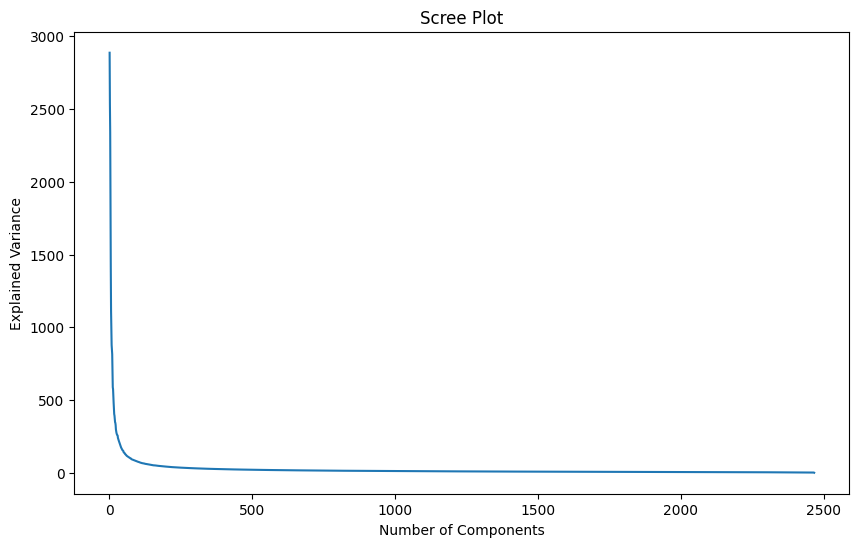

In [60]:
# Scree Plot
# Plotting Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca_loaded.explained_variance_) + 1), pca_loaded.explained_variance_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Scree Plot')
plt.show()

### Visualize Reduced Features using PCA and t-SNE

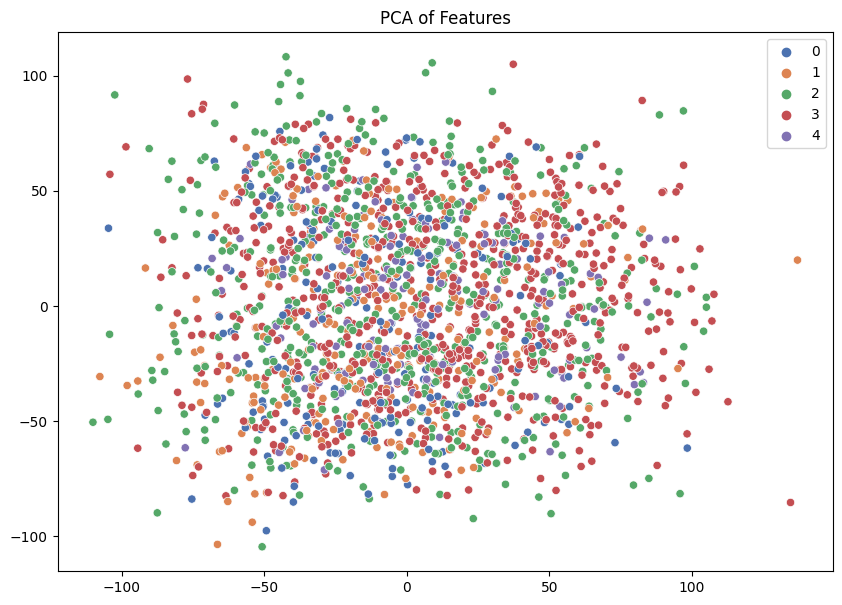

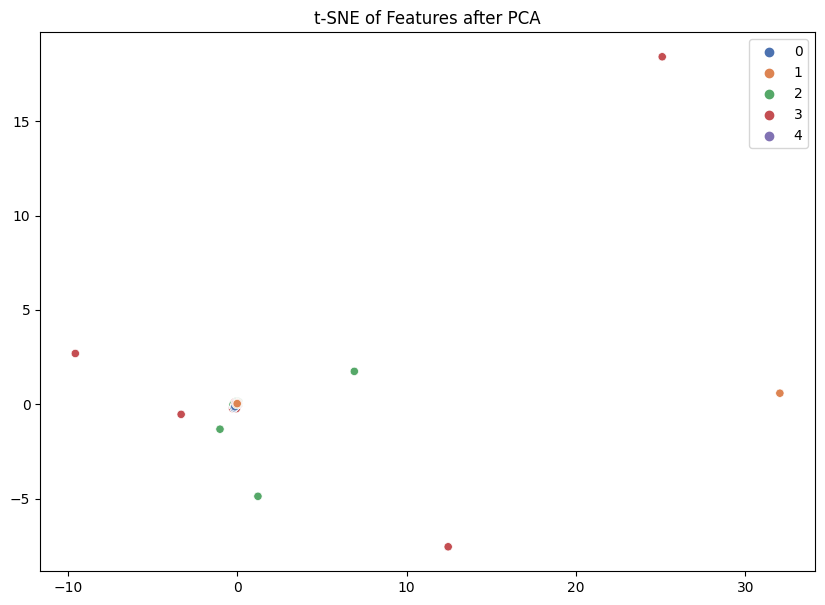

In [49]:
def visualize_reduced_features(features, labels):
    # PCA 2D Visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette="deep")
    plt.title('PCA of Features')
    plt.show()
    
    pca = PCA(n_components=1505)  # Reduce features to 1705 dimensions before t-SNE
    reduced_features2 = pca.fit_transform(features)

    # t-SNE 2D Visualization after PCA
    tsne = TSNE(n_components=2, perplexity=20, n_iter=250)
    tsne_result = tsne.fit_transform(reduced_features2)
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="deep")
    plt.title('t-SNE of Features after PCA')
    plt.show()

# Visualize using the loaded PCA model
visualize_reduced_features(X_train_pca, y_train)

# 4. Classification on Reduced Features

- Ensure that the train_test_split function preserves the class distribution by using stratify=labels to avoid imbalanced splits. This is especially useful if classes are imbalanced.

## 1. Implement Traditional Machine learning Classifiers


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# General PCA and Data Splitting Function
def prepare_data_with_pca(features, labels, test_size=0.2, random_state=42):
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=random_state, stratify=labels)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Perform PCA
    pca = PCA(n_components=1505)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    return X_train_pca, X_test_pca, y_train, y_test


In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt



In [52]:
# Helper function to perform classification
def classify_and_evaluate(model, param_grid, X_train, X_test, y_train, y_test, classifier_name):
    # Initialize GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Manual progress bar tracking
    total_combinations = np.prod([len(v) for v in param_grid.values()])
    progress_bar = tqdm(total=total_combinations, desc=f"Grid Search Progress - {classifier_name}")

    best_score = 0
    best_params = None

    # Loop through each combination of parameters
    for params in (dict(zip(param_grid, x)) for x in itertools.product(*param_grid.values())):
        # Set parameters for the model
        model.set_params(**params)

        # Fit the model and evaluate with cross-validation
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

        # Update best score and parameters
        mean_score = np.mean(scores)
        if mean_score > best_score:
            best_score = mean_score
            best_params = params

        # Update the progress bar
        progress_bar.update(1)

    # Close the progress bar
    progress_bar.close()

    # Output the best parameters and score
    print(f"Best Parameters for {classifier_name}: {best_params}")
    print(f"Best Cross-Validation Score for {classifier_name}: {best_score:.4f}")

    # Train the best model on the entire training set
    best_model = model.set_params(**best_params)
    best_model.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = best_model.predict(X_test)
    print(f"\nClassification Report for {classifier_name}:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {classifier_name}')
    plt.show()
    
    # AUC-ROC is especially useful for binary classification
    
#     # Calculate AUC-ROC
#     y_prob = best_model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
#     roc_auc = roc_auc_score(y_test, y_prob)
#     fpr, tpr, thresholds = roc_curve(y_test, y_prob)

#     # Plot ROC curve
#     plt.figure(figsize=(8, 6))
#     plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
#     plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title(f'ROC Curve - {classifier_name}')
#     plt.legend(loc='lower right')
#     plt.grid()
#     plt.show()

    return best_model

In [53]:
# Main function to run all classifiers
def run_all_classifiers(X_train, X_test, y_train, y_test):
    # SVM
    svm_model = SVC(kernel='rbf')
    svm_param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]}
    best_svm = classify_and_evaluate(svm_model, svm_param_grid, X_train, X_test, y_train, y_test, 'SVM')

    # Logistic Regression
    lr_model = LogisticRegression(max_iter=500)
    lr_param_grid = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
    best_lr = classify_and_evaluate(lr_model, lr_param_grid, X_train, X_test, y_train, y_test, 'Logistic Regression')

    # Random Forest
    rf_model = RandomForestClassifier()
    rf_param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10]}
    best_rf = classify_and_evaluate(rf_model, rf_param_grid, X_train, X_test, y_train, y_test, 'Random Forest')

    # XGBoost
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    xgb_param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 6, 9]}
    best_xgb = classify_and_evaluate(xgb_model, xgb_param_grid, X_train, X_test, y_train, y_test, 'XGBoost')

    return best_svm, best_lr, best_rf, best_xgb


In [ ]:
X_train_pca, X_test_pca, y_train, y_test = prepare_data_with_pca(features, labels, test_size=0.2, random_state=42)
import itertools

In [57]:
from sklearn.model_selection import cross_val_score




Grid Search Progress - SVM:   0%|          | 0/15 [00:00<?, ?it/s]

Grid Search Progress - SVM:   7%|▋         | 1/15 [00:15<03:37, 15.52s/it]

Grid Search Progress - SVM:  13%|█▎        | 2/15 [00:36<04:04, 18.81s/it]

Grid Search Progress - SVM:  20%|██        | 3/15 [00:57<03:55, 19.66s/it]

Grid Search Progress - SVM:  27%|██▋       | 4/15 [01:18<03:43, 20.35s/it]

Grid Search Progress - SVM:  33%|███▎      | 5/15 [01:38<03:22, 20.25s/it]

Grid Search Progress - SVM:  40%|████      | 6/15 [01:49<02:32, 17.00s/it]

Grid Search Progress - SVM:  47%|████▋     | 7/15 [02:09<02:23, 17.94s/it]

Grid Search Progress - SVM:  53%|█████▎    | 8/15 [02:28<02:09, 18.44s/it]

Grid Search Progress - SVM:  60%|██████    | 9/15 [02:50<01:55, 19.30s/it]

Grid Search Progress - SVM:  67%|██████▋   | 10/15 [03:10<01:38, 19.60s/it]

Grid Search Progress - SVM:  73%|███████▎  | 11/15 [03:22<01:09, 17.33s/it]

Grid Search Progress - SVM:  80%|████████  | 12/15 [03:42<00:54, 18.10s/it]

Grid Search Pro

Best Parameters for SVM: {'C': 10, 'gamma': 'scale'}
Best Cross-Validation Score for SVM: 0.9397

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96        58
           1       0.97      0.94      0.96        71
           2       0.91      0.91      0.91       144
           3       0.93      0.96      0.94       181
           4       0.97      0.95      0.96        40

    accuracy                           0.94       494
   macro avg       0.95      0.94      0.94       494
weighted avg       0.94      0.94      0.94       494



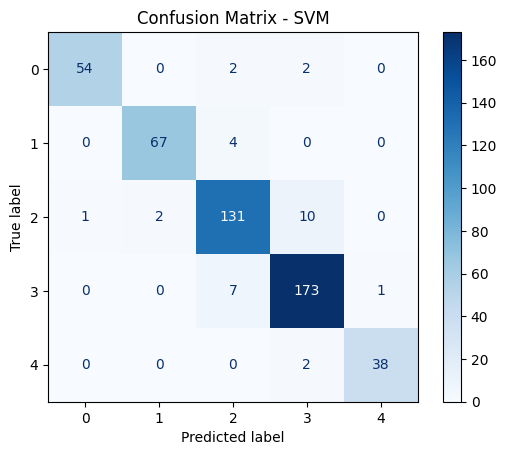



Grid Search Progress - Logistic Regression:   0%|          | 0/8 [00:00<?, ?it/s]

Grid Search Progress - Logistic Regression:  12%|█▎        | 1/8 [00:59<06:58, 59.74s/it]

Grid Search Progress - Logistic Regression:  25%|██▌       | 2/8 [01:11<03:08, 31.42s/it]

Grid Search Progress - Logistic Regression:  38%|███▊      | 3/8 [02:24<04:12, 50.46s/it]

Grid Search Progress - Logistic Regression:  50%|█████     | 4/8 [02:41<02:28, 37.12s/it]

Grid Search Progress - Logistic Regression:  62%|██████▎   | 5/8 [04:03<02:39, 53.27s/it]

Grid Search Progress - Logistic Regression:  75%|███████▌  | 6/8 [04:16<01:19, 39.75s/it]

Grid Search Progress - Logistic Regression:  88%|████████▊ | 7/8 [05:44<00:55, 55.49s/it]

Grid Search Progress - Logistic Regression: 100%|██████████| 8/8 [05:51<00:00, 43.91s/it]


Best Parameters for Logistic Regression: {'C': 10, 'solver': 'lbfgs'}
Best Cross-Validation Score for Logistic Regression: 0.9554

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        58
           1       0.97      0.96      0.96        71
           2       0.90      0.92      0.91       144
           3       0.95      0.95      0.95       181
           4       1.00      0.93      0.96        40

    accuracy                           0.94       494
   macro avg       0.96      0.94      0.95       494
weighted avg       0.94      0.94      0.94       494



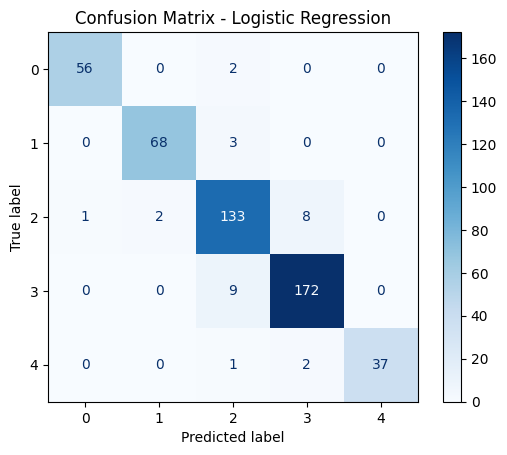



Grid Search Progress - Random Forest:   0%|          | 0/18 [00:00<?, ?it/s]

Grid Search Progress - Random Forest:   6%|▌         | 1/18 [00:23<06:41, 23.61s/it]

Grid Search Progress - Random Forest:  11%|█         | 2/18 [00:47<06:16, 23.52s/it]

Grid Search Progress - Random Forest:  17%|█▋        | 3/18 [01:10<05:50, 23.34s/it]

Grid Search Progress - Random Forest:  22%|██▏       | 4/18 [01:40<06:05, 26.14s/it]

Grid Search Progress - Random Forest:  28%|██▊       | 5/18 [02:10<05:59, 27.64s/it]

Grid Search Progress - Random Forest:  33%|███▎      | 6/18 [02:41<05:41, 28.47s/it]

Grid Search Progress - Random Forest:  39%|███▉      | 7/18 [03:12<05:25, 29.56s/it]

Grid Search Progress - Random Forest:  44%|████▍     | 8/18 [03:44<05:01, 30.14s/it]

Grid Search Progress - Random Forest:  50%|█████     | 9/18 [04:15<04:35, 30.66s/it]

Grid Search Progress - Random Forest:  56%|█████▌    | 10/18 [05:06<04:53, 36.68s/it]

Grid Search Progress - Random Forest:  61%|██████    | 11/1

Best Parameters for Random Forest: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 10}
Best Cross-Validation Score for Random Forest: 0.8965

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94        58
           1       0.96      0.66      0.78        71
           2       0.91      0.81      0.85       144
           3       0.74      0.97      0.84       181
           4       1.00      0.68      0.81        40

    accuracy                           0.85       494
   macro avg       0.91      0.80      0.84       494
weighted avg       0.87      0.85      0.84       494



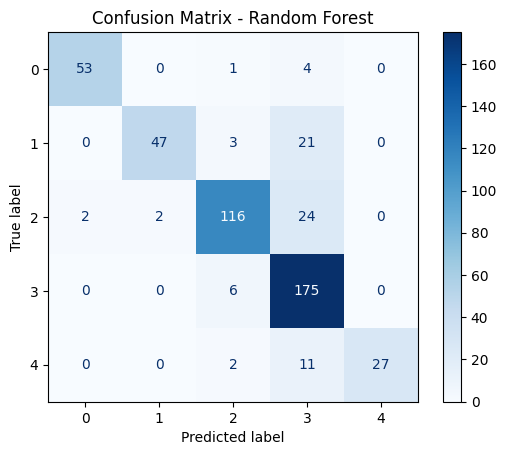



Grid Search Progress - XGBoost:   0%|          | 0/12 [00:00<?, ?it/s]

Grid Search Progress - XGBoost:   8%|▊         | 1/12 [02:28<27:13, 148.48s/it]

Grid Search Progress - XGBoost:  17%|█▋        | 2/12 [08:19<44:37, 267.73s/it]

Grid Search Progress - XGBoost:  25%|██▌       | 3/12 [15:35<51:38, 344.32s/it]

Grid Search Progress - XGBoost:  33%|███▎      | 4/12 [17:59<35:23, 265.49s/it]

Grid Search Progress - XGBoost:  42%|████▏     | 5/12 [21:57<29:48, 255.50s/it]

Grid Search Progress - XGBoost:  50%|█████     | 6/12 [26:16<25:39, 256.58s/it]

Grid Search Progress - XGBoost:  58%|█████▊    | 7/12 [31:10<22:24, 268.86s/it]

Grid Search Progress - XGBoost:  67%|██████▋   | 8/12 [42:46<26:58, 404.73s/it]

Grid Search Progress - XGBoost:  75%|███████▌  | 9/12 [56:44<27:01, 540.37s/it]

Grid Search Progress - XGBoost:  83%|████████▎ | 10/12 [1:00:45<14:55, 447.83s/it]

Grid Search Progress - XGBoost:  92%|█████████▏| 11/12 [1:06:07<06:49, 409.25s/it]

Grid Search Progress - XGBoos

Best Parameters for XGBoost: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3}
Best Cross-Validation Score for XGBoost: 0.9396

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95        58
           1       0.96      0.94      0.95        71
           2       0.89      0.85      0.87       144
           3       0.89      0.94      0.91       181
           4       1.00      0.95      0.97        40

    accuracy                           0.91       494
   macro avg       0.94      0.92      0.93       494
weighted avg       0.92      0.91      0.91       494



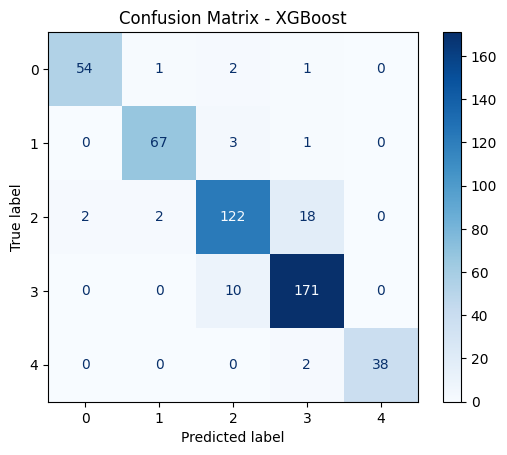

In [58]:
# Call the main function after splitting data and applying PCA
#X_train_pca, X_test_pca, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
best_svm, best_lr, best_rf, best_xgb = run_all_classifiers(X_train_pca, X_test_pca, y_train, y_test)

## 2. Implement a Neural Network


In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
import numpy as np

# Define hyperparameters
hidden_dim1 = 512
hidden_dim2 = 256
dropout_rate = 0.5

class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim1)  # First hidden layer
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)          # Second hidden layer
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(256, num_classes)  # Output layer
        self.dropout = nn.Dropout(0.5)          # Dropout for regularization

    def forward(self, x):
        x = self.dropout1(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
#         x = torch.relu(self.fc2(x))
#         x = self.dropout(x)
#         x = self.fc3(x)
        return x


In [86]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib
X_train2, X_test2, y_train2, y_test2 = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

scaler2 = StandardScaler()
X_train_scaled2 = scaler2.fit_transform(X_train2)
X_test_scaled2 = scaler2.transform(X_test2)

# Perform PCA
pca2 = PCA(n_components=1505)
X_train_pca2 = pca2.fit_transform(X_train_scaled2)
X_test_pca2 = pca2.transform(X_test_scaled2)

# Optionally, save the fitted PCA model for later use
joblib.dump(pca2, 'pca_model.pkl')


['pca_model.pkl']

In [60]:
# General PCA and Data Splitting Function
def prepare_data_with_pca(features, labels, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=random_state, stratify=labels)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Perform PCA
    pca = PCA(n_components=1505)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    return X_train_pca, X_test_pca, y_train, y_test

In [61]:
def evaluate_nn(model, features, labels, device):
    model.eval()
    with torch.no_grad():
        inputs = torch.FloatTensor(features).to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted.cpu() == labels).sum().item() / len(labels)
        print(f'Accuracy: {accuracy:.4f}')


In [62]:
def train_nn(model, X_train, y_train, X_val, y_val, device, epochs=50, batch_size=32, patience=5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()  # For multi-class classification
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch + 1}/{epochs}") as pbar:
            for inputs, targets in train_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_correct += (predicted == targets).sum().item()
                total_train += targets.size(0)

                pbar.set_postfix({'loss': loss.item()})
                pbar.update(1)
                
        # Calculate training accuracy
        train_accuracy = train_correct / total_train
        
        # Validation
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        model.eval()
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == targets).sum().item()
                total_val += targets.size(0)

        # Calculate validation accuracy
        val_accuracy = val_correct / total_val
        
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss / len(train_dataloader):.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss / len(val_dataloader):.4f}, '
              f'Val Accuracy: {val_accuracy:.4f}')
        
        # Early Stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            # Save the best model state
            torch.save(model.state_dict(), 'best_nn_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break


In [66]:
def k_fold_cross_validation(model_class, features, labels, device, k=5, epochs=50, batch_size_options=[32], learning_rate_options=[0.001]):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    best_accuracy = 0
    best_hyperparams = None
    best_model_state = None  # Variable to store the best model's state
    all_fold_accuracies = []  # Initialize this variable

    for learning_rate, batch_size in itertools.product(learning_rate_options, batch_size_options):
        print(f'Tuning: Learning Rate: {learning_rate}, Batch Size: {batch_size}')
        
        fold_accuracies = []

        for fold, (train_index, val_index) in enumerate(skf.split(features, labels)):
            print(f"Fold {fold + 1}/{k}")

            X_train, X_val = features[train_index], features[val_index]
            y_train, y_val = labels[train_index], labels[val_index]

            model = model_class(input_size=X_train.shape[1], num_classes=len(np.unique(labels)))
            
            train_nn(model, X_train, y_train, X_val, y_val, device, epochs, batch_size)

            # Evaluate on validation set
            val_accuracy = evaluate_nn(model, X_val, y_val, device)
            fold_accuracies.append(val_accuracy)
            #print(f'Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}')
            
        mean_accuracy = np.mean(fold_accuracies)
        all_fold_accuracies.append(mean_accuracy)
        
        # Update best accuracy and hyperparameters if necessary
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_hyperparams = (learning_rate, batch_size)
            best_model_state = model.state_dict()  # Save the current best model's state
        
        print(f'Best Hyperparameters: Learning Rate: {best_hyperparams[0]}, Batch Size: {best_hyperparams[1]}')
        print(f'Best Average Validation Accuracy: {best_accuracy:.4f}')

    # Save the best model after completing the search
    if best_model_state is not None:
        torch.save(best_model_state, 'best_nn_model.pth')
        print("Best model saved as 'best_nn_model.pth'")


In [67]:
# Example usage
#pca = pca_loaded
features_pca, test_features, labels_train, labels_test = prepare_data_with_pca(features, labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Perform k-fold cross-validation
#k_fold_cross_validation(SimpleNN, features_pca, labels_train, device)
#model = SimpleNN(input_size=features_pca.shape[1], num_classes=len(np.unique(labels)))


In [68]:
#k_fold_cross_validation(SimpleNN, features_pca, labels_train, device)

Tuning: Learning Rate: 0.001, Batch Size: 32
Fold 1/5




Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=1.63]

Epoch 1/50:   2%|▏         | 1/50 [00:00<00:01, 34.85it/s, loss=1.7]

Epoch 1/50:   4%|▍         | 2/50 [00:00<00:01, 46.30it/s, loss=1.52]

Epoch 1/50:   6%|▌         | 3/50 [00:00<00:00, 51.25it/s, loss=1.55]

Epoch 1/50:   8%|▊         | 4/50 [00:00<00:00, 55.01it/s, loss=1.35]

Epoch 1/50:  10%|█         | 5/50 [00:00<00:00, 57.96it/s, loss=1.3] 

Epoch 1/50:  12%|█▏        | 6/50 [00:00<00:00, 60.13it/s, loss=1.24]

Epoch 1/50:  14%|█▍        | 7/50 [00:00<00:00, 68.81it/s, loss=1.24]

Epoch 1/50:  14%|█▍        | 7/50 [00:00<00:00, 68.81it/s, loss=1.36]

Epoch 1/50:  16%|█▌        | 8/50 [00:00<00:00, 68.81it/s, loss=1.3] 

Epoch 1/50:  18%|█▊        | 9/50 [00:00<00:00, 68.81it/s, loss=1.16]

Epoch 1/50:  20%|██        | 10/50 [00:00<00:00, 68.81it/s, loss=1.14]

Epoch 1/50:  22%|██▏       | 11/50 [00:00<00:00, 68.81it/s, loss=0.837]

Epoch 1/50:  24%|██▍       | 

Epoch [1/50], Train Loss: 0.7993, Train Accuracy: 0.7127, Val Loss: 0.2391, Val Accuracy: 0.9443




Epoch 2/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.188]

Epoch 2/50:   2%|▏         | 1/50 [00:00<00:01, 44.98it/s, loss=0.193]

Epoch 2/50:   4%|▍         | 2/50 [00:00<00:00, 59.02it/s, loss=0.124]

Epoch 2/50:   6%|▌         | 3/50 [00:00<00:00, 65.14it/s, loss=0.307]

Epoch 2/50:   8%|▊         | 4/50 [00:00<00:00, 69.56it/s, loss=0.224]

Epoch 2/50:  10%|█         | 5/50 [00:00<00:00, 71.49it/s, loss=0.134]

Epoch 2/50:  12%|█▏        | 6/50 [00:00<00:00, 73.40it/s, loss=0.125]

Epoch 2/50:  14%|█▍        | 7/50 [00:00<00:00, 74.55it/s, loss=0.171]

Epoch 2/50:  16%|█▌        | 8/50 [00:00<00:00, 75.70it/s, loss=0.211]

Epoch 2/50:  18%|█▊        | 9/50 [00:00<00:00, 83.22it/s, loss=0.211]

Epoch 2/50:  18%|█▊        | 9/50 [00:00<00:00, 83.22it/s, loss=0.121]

Epoch 2/50:  20%|██        | 10/50 [00:00<00:00, 83.22it/s, loss=0.225]

Epoch 2/50:  22%|██▏       | 11/50 [00:00<00:00, 83.22it/s, loss=0.113]

Epoch 2/50:  24%

Epoch [2/50], Train Loss: 0.1413, Train Accuracy: 0.9765, Val Loss: 0.1838, Val Accuracy: 0.9468




Epoch 3/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0613]

Epoch 3/50:   2%|▏         | 1/50 [00:00<00:01, 38.88it/s, loss=0.0859]

Epoch 3/50:   4%|▍         | 2/50 [00:00<00:00, 53.30it/s, loss=0.0652]

Epoch 3/50:   6%|▌         | 3/50 [00:00<00:00, 60.58it/s, loss=0.0446]

Epoch 3/50:   8%|▊         | 4/50 [00:00<00:00, 65.15it/s, loss=0.095] 

Epoch 3/50:  10%|█         | 5/50 [00:00<00:00, 68.15it/s, loss=0.063]

Epoch 3/50:  12%|█▏        | 6/50 [00:00<00:00, 70.67it/s, loss=0.0466]

Epoch 3/50:  14%|█▍        | 7/50 [00:00<00:00, 72.65it/s, loss=0.0276]

Epoch 3/50:  16%|█▌        | 8/50 [00:00<00:00, 73.09it/s, loss=0.0692]

Epoch 3/50:  18%|█▊        | 9/50 [00:00<00:00, 80.95it/s, loss=0.0692]

Epoch 3/50:  18%|█▊        | 9/50 [00:00<00:00, 80.95it/s, loss=0.0574]

Epoch 3/50:  20%|██        | 10/50 [00:00<00:00, 80.95it/s, loss=0.0582]

Epoch 3/50:  22%|██▏       | 11/50 [00:00<00:00, 80.95it/s, loss=0.0953]

Epoc

Epoch [3/50], Train Loss: 0.0579, Train Accuracy: 0.9981, Val Loss: 0.1451, Val Accuracy: 0.9570




Epoch 4/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0223]

Epoch 4/50:   2%|▏         | 1/50 [00:00<00:01, 38.12it/s, loss=0.0232]

Epoch 4/50:   4%|▍         | 2/50 [00:00<00:00, 52.58it/s, loss=0.0251]

Epoch 4/50:   6%|▌         | 3/50 [00:00<00:00, 59.92it/s, loss=0.0444]

Epoch 4/50:   8%|▊         | 4/50 [00:00<00:00, 63.93it/s, loss=0.0246]

Epoch 4/50:  10%|█         | 5/50 [00:00<00:00, 66.63it/s, loss=0.0175]

Epoch 4/50:  12%|█▏        | 6/50 [00:00<00:00, 68.35it/s, loss=0.0142]

Epoch 4/50:  14%|█▍        | 7/50 [00:00<00:00, 69.95it/s, loss=0.0379]

Epoch 4/50:  16%|█▌        | 8/50 [00:00<00:00, 78.80it/s, loss=0.0379]

Epoch 4/50:  16%|█▌        | 8/50 [00:00<00:00, 78.80it/s, loss=0.0101]

Epoch 4/50:  18%|█▊        | 9/50 [00:00<00:00, 78.80it/s, loss=0.0258]

Epoch 4/50:  20%|██        | 10/50 [00:00<00:00, 78.80it/s, loss=0.0211]

Epoch 4/50:  22%|██▏       | 11/50 [00:00<00:00, 78.80it/s, loss=0.0396]

Epo

Epoch [4/50], Train Loss: 0.0316, Train Accuracy: 0.9968, Val Loss: 0.1551, Val Accuracy: 0.9443




Epoch 5/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0254]

Epoch 5/50:   2%|▏         | 1/50 [00:00<00:01, 44.78it/s, loss=0.0299]

Epoch 5/50:   4%|▍         | 2/50 [00:00<00:00, 58.72it/s, loss=0.0176]

Epoch 5/50:   6%|▌         | 3/50 [00:00<00:00, 65.84it/s, loss=0.016] 

Epoch 5/50:   8%|▊         | 4/50 [00:00<00:00, 69.58it/s, loss=0.0246]

Epoch 5/50:  10%|█         | 5/50 [00:00<00:00, 71.78it/s, loss=0.0203]

Epoch 5/50:  12%|█▏        | 6/50 [00:00<00:00, 73.74it/s, loss=0.0125]

Epoch 5/50:  14%|█▍        | 7/50 [00:00<00:00, 74.92it/s, loss=0.0137]

Epoch 5/50:  16%|█▌        | 8/50 [00:00<00:00, 76.30it/s, loss=0.0118]

Epoch 5/50:  18%|█▊        | 9/50 [00:00<00:00, 84.44it/s, loss=0.0118]

Epoch 5/50:  18%|█▊        | 9/50 [00:00<00:00, 84.44it/s, loss=0.0215]

Epoch 5/50:  20%|██        | 10/50 [00:00<00:00, 84.44it/s, loss=0.0838]

Epoch 5/50:  22%|██▏       | 11/50 [00:00<00:00, 84.44it/s, loss=0.00895]

Ep

Epoch [5/50], Train Loss: 0.0229, Train Accuracy: 0.9975, Val Loss: 0.1521, Val Accuracy: 0.9443




Epoch 6/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.00986]

Epoch 6/50:   2%|▏         | 1/50 [00:00<00:01, 43.84it/s, loss=0.0537]

Epoch 6/50:   4%|▍         | 2/50 [00:00<00:00, 56.49it/s, loss=0.00892]

Epoch 6/50:   6%|▌         | 3/50 [00:00<00:00, 62.25it/s, loss=0.00461]

Epoch 6/50:   8%|▊         | 4/50 [00:00<00:00, 65.97it/s, loss=0.0332] 

Epoch 6/50:  10%|█         | 5/50 [00:00<00:00, 68.11it/s, loss=0.00939]

Epoch 6/50:  12%|█▏        | 6/50 [00:00<00:00, 70.11it/s, loss=0.00794]

Epoch 6/50:  14%|█▍        | 7/50 [00:00<00:00, 71.26it/s, loss=0.0106] 

Epoch 6/50:  16%|█▌        | 8/50 [00:00<00:00, 79.79it/s, loss=0.0106]

Epoch 6/50:  16%|█▌        | 8/50 [00:00<00:00, 79.79it/s, loss=0.0308]

Epoch 6/50:  18%|█▊        | 9/50 [00:00<00:00, 79.79it/s, loss=0.00968]

Epoch 6/50:  20%|██        | 10/50 [00:00<00:00, 79.79it/s, loss=0.00451]

Epoch 6/50:  22%|██▏       | 11/50 [00:00<00:00, 79.79it/s, loss=0.0

Epoch [6/50], Train Loss: 0.0142, Train Accuracy: 0.9994, Val Loss: 0.1667, Val Accuracy: 0.9392




Epoch 7/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.011]

Epoch 7/50:   2%|▏         | 1/50 [00:00<00:01, 46.57it/s, loss=0.0175]

Epoch 7/50:   4%|▍         | 2/50 [00:00<00:00, 59.30it/s, loss=0.00865]

Epoch 7/50:   6%|▌         | 3/50 [00:00<00:00, 65.65it/s, loss=0.00941]

Epoch 7/50:   8%|▊         | 4/50 [00:00<00:00, 69.60it/s, loss=0.00329]

Epoch 7/50:  10%|█         | 5/50 [00:00<00:00, 72.20it/s, loss=0.008]  

Epoch 7/50:  12%|█▏        | 6/50 [00:00<00:00, 73.76it/s, loss=0.0164]

Epoch 7/50:  14%|█▍        | 7/50 [00:00<00:00, 74.76it/s, loss=0.00417]

Epoch 7/50:  16%|█▌        | 8/50 [00:00<00:00, 75.71it/s, loss=0.0172] 

Epoch 7/50:  18%|█▊        | 9/50 [00:00<00:00, 83.80it/s, loss=0.0172]

Epoch 7/50:  18%|█▊        | 9/50 [00:00<00:00, 83.80it/s, loss=0.00772]

Epoch 7/50:  20%|██        | 10/50 [00:00<00:00, 83.80it/s, loss=0.0118]

Epoch 7/50:  22%|██▏       | 11/50 [00:00<00:00, 83.80it/s, loss=0.0047

Epoch [7/50], Train Loss: 0.0120, Train Accuracy: 1.0000, Val Loss: 0.1494, Val Accuracy: 0.9392




Epoch 8/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.00492]

Epoch 8/50:   2%|▏         | 1/50 [00:00<00:01, 46.05it/s, loss=0.00434]

Epoch 8/50:   4%|▍         | 2/50 [00:00<00:00, 59.04it/s, loss=0.00727]

Epoch 8/50:   6%|▌         | 3/50 [00:00<00:00, 64.83it/s, loss=0.00428]

Epoch 8/50:   8%|▊         | 4/50 [00:00<00:00, 68.48it/s, loss=0.00579]

Epoch 8/50:  10%|█         | 5/50 [00:00<00:00, 70.85it/s, loss=0.00363]

Epoch 8/50:  12%|█▏        | 6/50 [00:00<00:00, 72.88it/s, loss=0.00488]

Epoch 8/50:  14%|█▍        | 7/50 [00:00<00:00, 74.34it/s, loss=0.00951]

Epoch 8/50:  16%|█▌        | 8/50 [00:00<00:00, 75.32it/s, loss=0.00783]

Epoch 8/50:  18%|█▊        | 9/50 [00:00<00:00, 83.33it/s, loss=0.00783]

Epoch 8/50:  18%|█▊        | 9/50 [00:00<00:00, 83.33it/s, loss=0.00404]

Epoch 8/50:  20%|██        | 10/50 [00:00<00:00, 83.33it/s, loss=0.00228]

Epoch 8/50:  22%|██▏       | 11/50 [00:00<00:00, 83.33it/s, loss=

Epoch [8/50], Train Loss: 0.0092, Train Accuracy: 0.9994, Val Loss: 0.1467, Val Accuracy: 0.9392
Early stopping triggered!
Accuracy: 0.9392
Fold 2/5




Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=1.59]

Epoch 1/50:   2%|▏         | 1/50 [00:00<00:01, 36.77it/s, loss=1.67]

Epoch 1/50:   4%|▍         | 2/50 [00:00<00:00, 50.22it/s, loss=1.64]

Epoch 1/50:   6%|▌         | 3/50 [00:00<00:00, 57.61it/s, loss=1.55]

Epoch 1/50:   8%|▊         | 4/50 [00:00<00:00, 62.22it/s, loss=1.48]

Epoch 1/50:  10%|█         | 5/50 [00:00<00:00, 65.16it/s, loss=1.51]

Epoch 1/50:  12%|█▏        | 6/50 [00:00<00:00, 67.40it/s, loss=1.18]

Epoch 1/50:  14%|█▍        | 7/50 [00:00<00:00, 69.14it/s, loss=1.26]

Epoch 1/50:  16%|█▌        | 8/50 [00:00<00:00, 77.83it/s, loss=1.26]

Epoch 1/50:  16%|█▌        | 8/50 [00:00<00:00, 77.83it/s, loss=1.19]

Epoch 1/50:  18%|█▊        | 9/50 [00:00<00:00, 77.83it/s, loss=1.22]

Epoch 1/50:  20%|██        | 10/50 [00:00<00:00, 77.83it/s, loss=1.13]

Epoch 1/50:  22%|██▏       | 11/50 [00:00<00:00, 77.83it/s, loss=1.15]

Epoch 1/50:  24%|██▍       | 

Epoch [1/50], Train Loss: 0.7728, Train Accuracy: 0.7324, Val Loss: 0.2788, Val Accuracy: 0.9367




Epoch 2/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.132]

Epoch 2/50:   2%|▏         | 1/50 [00:00<00:01, 43.43it/s, loss=0.262]

Epoch 2/50:   4%|▍         | 2/50 [00:00<00:00, 53.24it/s, loss=0.234]

Epoch 2/50:   6%|▌         | 3/50 [00:00<00:00, 57.13it/s, loss=0.207]

Epoch 2/50:   8%|▊         | 4/50 [00:00<00:00, 59.29it/s, loss=0.144]

Epoch 2/50:  10%|█         | 5/50 [00:00<00:00, 60.84it/s, loss=0.203]

Epoch 2/50:  12%|█▏        | 6/50 [00:00<00:00, 62.29it/s, loss=0.163]

Epoch 2/50:  14%|█▍        | 7/50 [00:00<00:00, 63.52it/s, loss=0.122]

Epoch 2/50:  16%|█▌        | 8/50 [00:00<00:00, 71.50it/s, loss=0.122]

Epoch 2/50:  16%|█▌        | 8/50 [00:00<00:00, 71.50it/s, loss=0.181]

Epoch 2/50:  18%|█▊        | 9/50 [00:00<00:00, 71.50it/s, loss=0.0983]

Epoch 2/50:  20%|██        | 10/50 [00:00<00:00, 71.50it/s, loss=0.142]

Epoch 2/50:  22%|██▏       | 11/50 [00:00<00:00, 71.50it/s, loss=0.104]

Epoch 2/50:  24

Epoch [2/50], Train Loss: 0.1315, Train Accuracy: 0.9810, Val Loss: 0.2305, Val Accuracy: 0.9367




Epoch 3/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.059]

Epoch 3/50:   2%|▏         | 1/50 [00:00<00:01, 37.51it/s, loss=0.0588]

Epoch 3/50:   4%|▍         | 2/50 [00:00<00:00, 51.75it/s, loss=0.0486]

Epoch 3/50:   6%|▌         | 3/50 [00:00<00:00, 60.11it/s, loss=0.0434]

Epoch 3/50:   8%|▊         | 4/50 [00:00<00:00, 65.24it/s, loss=0.0387]

Epoch 3/50:  10%|█         | 5/50 [00:00<00:00, 69.11it/s, loss=0.0302]

Epoch 3/50:  12%|█▏        | 6/50 [00:00<00:00, 72.00it/s, loss=0.0337]

Epoch 3/50:  14%|█▍        | 7/50 [00:00<00:00, 74.11it/s, loss=0.0326]

Epoch 3/50:  16%|█▌        | 8/50 [00:00<00:00, 75.80it/s, loss=0.0392]

Epoch 3/50:  18%|█▊        | 9/50 [00:00<00:00, 84.11it/s, loss=0.0392]

Epoch 3/50:  18%|█▊        | 9/50 [00:00<00:00, 84.11it/s, loss=0.0603]

Epoch 3/50:  20%|██        | 10/50 [00:00<00:00, 84.11it/s, loss=0.0776]

Epoch 3/50:  22%|██▏       | 11/50 [00:00<00:00, 84.11it/s, loss=0.0243]

Epoc

Epoch [3/50], Train Loss: 0.0523, Train Accuracy: 0.9949, Val Loss: 0.1961, Val Accuracy: 0.9519




Epoch 4/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0121]

Epoch 4/50:   2%|▏         | 1/50 [00:00<00:01, 41.24it/s, loss=0.0212]

Epoch 4/50:   4%|▍         | 2/50 [00:00<00:00, 54.61it/s, loss=0.015] 

Epoch 4/50:   6%|▌         | 3/50 [00:00<00:00, 61.95it/s, loss=0.0283]

Epoch 4/50:   8%|▊         | 4/50 [00:00<00:00, 66.19it/s, loss=0.0265]

Epoch 4/50:  10%|█         | 5/50 [00:00<00:00, 67.14it/s, loss=0.0155]

Epoch 4/50:  12%|█▏        | 6/50 [00:00<00:00, 68.72it/s, loss=0.0268]

Epoch 4/50:  14%|█▍        | 7/50 [00:00<00:00, 69.17it/s, loss=0.0184]

Epoch 4/50:  16%|█▌        | 8/50 [00:00<00:00, 77.57it/s, loss=0.0184]

Epoch 4/50:  16%|█▌        | 8/50 [00:00<00:00, 77.57it/s, loss=0.025] 

Epoch 4/50:  18%|█▊        | 9/50 [00:00<00:00, 77.57it/s, loss=0.0206]

Epoch 4/50:  20%|██        | 10/50 [00:00<00:00, 77.57it/s, loss=0.0213]

Epoch 4/50:  22%|██▏       | 11/50 [00:00<00:00, 77.57it/s, loss=0.0304]

Epo

Epoch [4/50], Train Loss: 0.0320, Train Accuracy: 0.9968, Val Loss: 0.1947, Val Accuracy: 0.9494




Epoch 5/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0106]

Epoch 5/50:   2%|▏         | 1/50 [00:00<00:01, 37.29it/s, loss=0.0295]

Epoch 5/50:   4%|▍         | 2/50 [00:00<00:00, 48.70it/s, loss=0.00927]

Epoch 5/50:   6%|▌         | 3/50 [00:00<00:00, 54.39it/s, loss=0.00433]

Epoch 5/50:   8%|▊         | 4/50 [00:00<00:00, 57.57it/s, loss=0.00909]

Epoch 5/50:  10%|█         | 5/50 [00:00<00:00, 59.72it/s, loss=0.0121] 

Epoch 5/50:  12%|█▏        | 6/50 [00:00<00:00, 63.00it/s, loss=0.00795]

Epoch 5/50:  14%|█▍        | 7/50 [00:00<00:00, 65.41it/s, loss=0.0814] 

Epoch 5/50:  16%|█▌        | 8/50 [00:00<00:00, 73.75it/s, loss=0.0814]

Epoch 5/50:  16%|█▌        | 8/50 [00:00<00:00, 73.75it/s, loss=0.0138]

Epoch 5/50:  18%|█▊        | 9/50 [00:00<00:00, 73.75it/s, loss=0.00945]

Epoch 5/50:  20%|██        | 10/50 [00:00<00:00, 73.75it/s, loss=0.0131]

Epoch 5/50:  22%|██▏       | 11/50 [00:00<00:00, 73.75it/s, loss=0.006

Epoch [5/50], Train Loss: 0.0185, Train Accuracy: 0.9987, Val Loss: 0.1853, Val Accuracy: 0.9443




Epoch 6/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0101]

Epoch 6/50:   2%|▏         | 1/50 [00:00<00:01, 45.90it/s, loss=0.0698]

Epoch 6/50:   4%|▍         | 2/50 [00:00<00:00, 59.76it/s, loss=0.00764]

Epoch 6/50:   6%|▌         | 3/50 [00:00<00:00, 66.39it/s, loss=0.0104] 

Epoch 6/50:   8%|▊         | 4/50 [00:00<00:00, 69.94it/s, loss=0.00676]

Epoch 6/50:  10%|█         | 5/50 [00:00<00:00, 72.75it/s, loss=0.0092] 

Epoch 6/50:  12%|█▏        | 6/50 [00:00<00:00, 74.03it/s, loss=0.00836]

Epoch 6/50:  14%|█▍        | 7/50 [00:00<00:00, 75.72it/s, loss=0.0147] 

Epoch 6/50:  16%|█▌        | 8/50 [00:00<00:00, 76.83it/s, loss=0.0169]

Epoch 6/50:  18%|█▊        | 9/50 [00:00<00:00, 85.03it/s, loss=0.0169]

Epoch 6/50:  18%|█▊        | 9/50 [00:00<00:00, 85.03it/s, loss=0.0215]

Epoch 6/50:  20%|██        | 10/50 [00:00<00:00, 85.03it/s, loss=0.0156]

Epoch 6/50:  22%|██▏       | 11/50 [00:00<00:00, 85.03it/s, loss=0.0063

Epoch [6/50], Train Loss: 0.0158, Train Accuracy: 0.9987, Val Loss: 0.1729, Val Accuracy: 0.9519




Epoch 7/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.00753]

Epoch 7/50:   2%|▏         | 1/50 [00:00<00:01, 44.55it/s, loss=0.00828]

Epoch 7/50:   4%|▍         | 2/50 [00:00<00:00, 58.98it/s, loss=0.00407]

Epoch 7/50:   6%|▌         | 3/50 [00:00<00:00, 66.06it/s, loss=0.00332]

Epoch 7/50:   8%|▊         | 4/50 [00:00<00:00, 69.76it/s, loss=0.00368]

Epoch 7/50:  10%|█         | 5/50 [00:00<00:00, 72.84it/s, loss=0.00269]

Epoch 7/50:  12%|█▏        | 6/50 [00:00<00:00, 74.93it/s, loss=0.00391]

Epoch 7/50:  14%|█▍        | 7/50 [00:00<00:00, 76.49it/s, loss=0.00719]

Epoch 7/50:  16%|█▌        | 8/50 [00:00<00:00, 77.59it/s, loss=0.00221]

Epoch 7/50:  18%|█▊        | 9/50 [00:00<00:00, 85.26it/s, loss=0.00221]

Epoch 7/50:  18%|█▊        | 9/50 [00:00<00:00, 85.26it/s, loss=0.0193] 

Epoch 7/50:  20%|██        | 10/50 [00:00<00:00, 85.26it/s, loss=0.00774]

Epoch 7/50:  22%|██▏       | 11/50 [00:00<00:00, 85.26it/s, loss=

Epoch [7/50], Train Loss: 0.0092, Train Accuracy: 1.0000, Val Loss: 0.1763, Val Accuracy: 0.9342




Epoch 8/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.00329]

Epoch 8/50:   2%|▏         | 1/50 [00:00<00:01, 42.19it/s, loss=0.00429]

Epoch 8/50:   4%|▍         | 2/50 [00:00<00:00, 55.73it/s, loss=0.00277]

Epoch 8/50:   6%|▌         | 3/50 [00:00<00:00, 62.49it/s, loss=0.00685]

Epoch 8/50:   8%|▊         | 4/50 [00:00<00:00, 66.19it/s, loss=0.00416]

Epoch 8/50:  10%|█         | 5/50 [00:00<00:00, 68.69it/s, loss=0.00352]

Epoch 8/50:  12%|█▏        | 6/50 [00:00<00:00, 70.32it/s, loss=0.0437] 

Epoch 8/50:  14%|█▍        | 7/50 [00:00<00:00, 71.17it/s, loss=0.007] 

Epoch 8/50:  16%|█▌        | 8/50 [00:00<00:00, 79.98it/s, loss=0.007]

Epoch 8/50:  16%|█▌        | 8/50 [00:00<00:00, 79.98it/s, loss=0.136]

Epoch 8/50:  18%|█▊        | 9/50 [00:00<00:00, 79.98it/s, loss=0.00506]

Epoch 8/50:  20%|██        | 10/50 [00:00<00:00, 79.98it/s, loss=0.00335]

Epoch 8/50:  22%|██▏       | 11/50 [00:00<00:00, 79.98it/s, loss=0.007

Epoch [8/50], Train Loss: 0.0140, Train Accuracy: 0.9981, Val Loss: 0.1497, Val Accuracy: 0.9620




Epoch 9/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0023]

Epoch 9/50:   2%|▏         | 1/50 [00:00<00:01, 36.69it/s, loss=0.00779]

Epoch 9/50:   4%|▍         | 2/50 [00:00<00:01, 46.23it/s, loss=0.00349]

Epoch 9/50:   6%|▌         | 3/50 [00:00<00:00, 52.24it/s, loss=0.0142] 

Epoch 9/50:   8%|▊         | 4/50 [00:00<00:00, 57.51it/s, loss=0.00594]

Epoch 9/50:  10%|█         | 5/50 [00:00<00:00, 61.52it/s, loss=0.00571]

Epoch 9/50:  12%|█▏        | 6/50 [00:00<00:00, 64.41it/s, loss=0.00564]

Epoch 9/50:  14%|█▍        | 7/50 [00:00<00:00, 66.82it/s, loss=0.00223]

Epoch 9/50:  16%|█▌        | 8/50 [00:00<00:00, 75.14it/s, loss=0.00223]

Epoch 9/50:  16%|█▌        | 8/50 [00:00<00:00, 75.14it/s, loss=0.00593]

Epoch 9/50:  18%|█▊        | 9/50 [00:00<00:00, 75.14it/s, loss=0.00342]

Epoch 9/50:  20%|██        | 10/50 [00:00<00:00, 75.14it/s, loss=0.00138]

Epoch 9/50:  22%|██▏       | 11/50 [00:00<00:00, 75.14it/s, loss=0

Epoch [9/50], Train Loss: 0.0097, Train Accuracy: 0.9981, Val Loss: 0.2155, Val Accuracy: 0.9266




Epoch 10/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.00432]

Epoch 10/50:   2%|▏         | 1/50 [00:00<00:01, 43.88it/s, loss=0.00383]

Epoch 10/50:   4%|▍         | 2/50 [00:00<00:00, 58.15it/s, loss=0.00641]

Epoch 10/50:   6%|▌         | 3/50 [00:00<00:00, 65.07it/s, loss=0.0139] 

Epoch 10/50:   8%|▊         | 4/50 [00:00<00:00, 69.15it/s, loss=0.0103]

Epoch 10/50:  10%|█         | 5/50 [00:00<00:00, 71.95it/s, loss=0.00529]

Epoch 10/50:  12%|█▏        | 6/50 [00:00<00:00, 73.73it/s, loss=0.002]  

Epoch 10/50:  14%|█▍        | 7/50 [00:00<00:00, 75.11it/s, loss=0.0139]

Epoch 10/50:  16%|█▌        | 8/50 [00:00<00:00, 76.26it/s, loss=0.0136]

Epoch 10/50:  18%|█▊        | 9/50 [00:00<00:00, 84.38it/s, loss=0.0136]

Epoch 10/50:  18%|█▊        | 9/50 [00:00<00:00, 84.38it/s, loss=0.00408]

Epoch 10/50:  20%|██        | 10/50 [00:00<00:00, 84.38it/s, loss=0.00146]

Epoch 10/50:  22%|██▏       | 11/50 [00:00<00:00, 84.38i

Epoch [10/50], Train Loss: 0.0082, Train Accuracy: 0.9994, Val Loss: 0.1464, Val Accuracy: 0.9519




Epoch 11/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.00459]

Epoch 11/50:   2%|▏         | 1/50 [00:00<00:01, 38.31it/s, loss=0.00458]

Epoch 11/50:   4%|▍         | 2/50 [00:00<00:01, 47.80it/s, loss=0.00328]

Epoch 11/50:   6%|▌         | 3/50 [00:00<00:00, 55.23it/s, loss=0.00222]

Epoch 11/50:   8%|▊         | 4/50 [00:00<00:00, 59.35it/s, loss=0.00217]

Epoch 11/50:  10%|█         | 5/50 [00:00<00:00, 62.15it/s, loss=0.00189]

Epoch 11/50:  12%|█▏        | 6/50 [00:00<00:00, 64.02it/s, loss=0.00372]

Epoch 11/50:  14%|█▍        | 7/50 [00:00<00:00, 65.83it/s, loss=0.0114] 

Epoch 11/50:  16%|█▌        | 8/50 [00:00<00:00, 74.16it/s, loss=0.0114]

Epoch 11/50:  16%|█▌        | 8/50 [00:00<00:00, 74.16it/s, loss=0.00257]

Epoch 11/50:  18%|█▊        | 9/50 [00:00<00:00, 74.16it/s, loss=0.0131] 

Epoch 11/50:  20%|██        | 10/50 [00:00<00:00, 74.16it/s, loss=0.00291]

Epoch 11/50:  22%|██▏       | 11/50 [00:00<00:00, 74.

Epoch [11/50], Train Loss: 0.0048, Train Accuracy: 1.0000, Val Loss: 0.1566, Val Accuracy: 0.9544




Epoch 12/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.00355]

Epoch 12/50:   2%|▏         | 1/50 [00:00<00:01, 45.80it/s, loss=0.014]

Epoch 12/50:   4%|▍         | 2/50 [00:00<00:00, 59.34it/s, loss=0.00354]

Epoch 12/50:   6%|▌         | 3/50 [00:00<00:00, 66.60it/s, loss=0.00297]

Epoch 12/50:   8%|▊         | 4/50 [00:00<00:00, 70.67it/s, loss=0.00266]

Epoch 12/50:  10%|█         | 5/50 [00:00<00:00, 73.57it/s, loss=0.00327]

Epoch 12/50:  12%|█▏        | 6/50 [00:00<00:00, 75.53it/s, loss=0.000481]

Epoch 12/50:  14%|█▍        | 7/50 [00:00<00:00, 77.12it/s, loss=0.00362] 

Epoch 12/50:  16%|█▌        | 8/50 [00:00<00:00, 78.11it/s, loss=0.00131]

Epoch 12/50:  18%|█▊        | 9/50 [00:00<00:00, 86.35it/s, loss=0.00131]

Epoch 12/50:  18%|█▊        | 9/50 [00:00<00:00, 86.35it/s, loss=0.0053] 

Epoch 12/50:  20%|██        | 10/50 [00:00<00:00, 86.35it/s, loss=0.00324]

Epoch 12/50:  22%|██▏       | 11/50 [00:00<00:00, 86

Epoch [12/50], Train Loss: 0.0047, Train Accuracy: 1.0000, Val Loss: 0.1617, Val Accuracy: 0.9392




Epoch 13/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.00297]

Epoch 13/50:   2%|▏         | 1/50 [00:00<00:01, 45.74it/s, loss=0.007]

Epoch 13/50:   4%|▍         | 2/50 [00:00<00:00, 60.28it/s, loss=0.0057]

Epoch 13/50:   6%|▌         | 3/50 [00:00<00:00, 66.76it/s, loss=0.000797]

Epoch 13/50:   8%|▊         | 4/50 [00:00<00:00, 70.18it/s, loss=0.0032]  

Epoch 13/50:  10%|█         | 5/50 [00:00<00:00, 72.66it/s, loss=0.0086]

Epoch 13/50:  12%|█▏        | 6/50 [00:00<00:00, 74.41it/s, loss=0.00076]

Epoch 13/50:  14%|█▍        | 7/50 [00:00<00:00, 75.80it/s, loss=0.00257]

Epoch 13/50:  16%|█▌        | 8/50 [00:00<00:00, 76.91it/s, loss=0.00122]

Epoch 13/50:  18%|█▊        | 9/50 [00:00<00:00, 85.11it/s, loss=0.00122]

Epoch 13/50:  18%|█▊        | 9/50 [00:00<00:00, 85.11it/s, loss=0.028]  

Epoch 13/50:  20%|██        | 10/50 [00:00<00:00, 85.11it/s, loss=0.00383]

Epoch 13/50:  22%|██▏       | 11/50 [00:00<00:00, 85.1

Epoch [13/50], Train Loss: 0.0064, Train Accuracy: 0.9981, Val Loss: 0.1852, Val Accuracy: 0.9291




Epoch 14/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0303]

Epoch 14/50:   2%|▏         | 1/50 [00:00<00:01, 48.39it/s, loss=0.00298]

Epoch 14/50:   4%|▍         | 2/50 [00:00<00:00, 62.16it/s, loss=0.00133]

Epoch 14/50:   6%|▌         | 3/50 [00:00<00:00, 68.58it/s, loss=0.00216]

Epoch 14/50:   8%|▊         | 4/50 [00:00<00:00, 72.13it/s, loss=0.00151]

Epoch 14/50:  10%|█         | 5/50 [00:00<00:00, 74.86it/s, loss=0.00766]

Epoch 14/50:  12%|█▏        | 6/50 [00:00<00:00, 76.66it/s, loss=0.00343]

Epoch 14/50:  14%|█▍        | 7/50 [00:00<00:00, 78.01it/s, loss=0.000913]

Epoch 14/50:  16%|█▌        | 8/50 [00:00<00:00, 79.14it/s, loss=0.00291] 

Epoch 14/50:  18%|█▊        | 9/50 [00:00<00:00, 87.52it/s, loss=0.00291]

Epoch 14/50:  18%|█▊        | 9/50 [00:00<00:00, 87.52it/s, loss=0.00594]

Epoch 14/50:  20%|██        | 10/50 [00:00<00:00, 87.52it/s, loss=0.00249]

Epoch 14/50:  22%|██▏       | 11/50 [00:00<00:00, 8

Epoch [14/50], Train Loss: 0.0035, Train Accuracy: 1.0000, Val Loss: 0.1723, Val Accuracy: 0.9443




Epoch 15/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0037]

Epoch 15/50:   2%|▏         | 1/50 [00:00<00:01, 43.85it/s, loss=0.00195]

Epoch 15/50:   4%|▍         | 2/50 [00:00<00:00, 57.38it/s, loss=0.000515]

Epoch 15/50:   6%|▌         | 3/50 [00:00<00:00, 63.61it/s, loss=0.00112] 

Epoch 15/50:   8%|▊         | 4/50 [00:00<00:00, 67.27it/s, loss=0.0011] 

Epoch 15/50:  10%|█         | 5/50 [00:00<00:00, 69.49it/s, loss=0.00335]

Epoch 15/50:  12%|█▏        | 6/50 [00:00<00:00, 71.09it/s, loss=0.00399]

Epoch 15/50:  14%|█▍        | 7/50 [00:00<00:00, 71.99it/s, loss=0.00101]

Epoch 15/50:  16%|█▌        | 8/50 [00:00<00:00, 73.20it/s, loss=0.00301]

Epoch 15/50:  18%|█▊        | 9/50 [00:00<00:00, 80.97it/s, loss=0.00301]

Epoch 15/50:  18%|█▊        | 9/50 [00:00<00:00, 80.97it/s, loss=0.00533]

Epoch 15/50:  20%|██        | 10/50 [00:00<00:00, 80.97it/s, loss=0.00227]

Epoch 15/50:  22%|██▏       | 11/50 [00:00<00:00, 8

Epoch [15/50], Train Loss: 0.0039, Train Accuracy: 1.0000, Val Loss: 0.1759, Val Accuracy: 0.9494
Early stopping triggered!
Accuracy: 0.9494
Fold 3/5




Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=1.76]

Epoch 1/50:   2%|▏         | 1/50 [00:00<00:01, 40.60it/s, loss=1.78]

Epoch 1/50:   4%|▍         | 2/50 [00:00<00:00, 54.03it/s, loss=1.58]

Epoch 1/50:   6%|▌         | 3/50 [00:00<00:00, 61.17it/s, loss=1.28]

Epoch 1/50:   8%|▊         | 4/50 [00:00<00:00, 65.14it/s, loss=1.54]

Epoch 1/50:  10%|█         | 5/50 [00:00<00:00, 67.55it/s, loss=1.54]

Epoch 1/50:  12%|█▏        | 6/50 [00:00<00:00, 69.02it/s, loss=1.33]

Epoch 1/50:  14%|█▍        | 7/50 [00:00<00:00, 68.17it/s, loss=1.46]

Epoch 1/50:  16%|█▌        | 8/50 [00:00<00:00, 75.81it/s, loss=1.46]

Epoch 1/50:  16%|█▌        | 8/50 [00:00<00:00, 75.81it/s, loss=1.24]

Epoch 1/50:  18%|█▊        | 9/50 [00:00<00:00, 75.81it/s, loss=1.15]

Epoch 1/50:  20%|██        | 10/50 [00:00<00:00, 75.81it/s, loss=1.03]

Epoch 1/50:  22%|██▏       | 11/50 [00:00<00:00, 75.81it/s, loss=1.05]

Epoch 1/50:  24%|██▍       | 

Epoch [1/50], Train Loss: 0.7864, Train Accuracy: 0.7224, Val Loss: 0.2637, Val Accuracy: 0.9391




Epoch 2/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.146]

Epoch 2/50:   2%|▏         | 1/50 [00:00<00:01, 41.43it/s, loss=0.274]

Epoch 2/50:   4%|▍         | 2/50 [00:00<00:00, 54.82it/s, loss=0.304]

Epoch 2/50:   6%|▌         | 3/50 [00:00<00:00, 61.07it/s, loss=0.175]

Epoch 2/50:   8%|▊         | 4/50 [00:00<00:00, 65.02it/s, loss=0.173]

Epoch 2/50:  10%|█         | 5/50 [00:00<00:00, 67.91it/s, loss=0.228]

Epoch 2/50:  12%|█▏        | 6/50 [00:00<00:00, 69.37it/s, loss=0.12] 

Epoch 2/50:  14%|█▍        | 7/50 [00:00<00:00, 70.92it/s, loss=0.172]

Epoch 2/50:  16%|█▌        | 8/50 [00:00<00:00, 79.27it/s, loss=0.172]

Epoch 2/50:  16%|█▌        | 8/50 [00:00<00:00, 79.27it/s, loss=0.115]

Epoch 2/50:  18%|█▊        | 9/50 [00:00<00:00, 79.27it/s, loss=0.162]

Epoch 2/50:  20%|██        | 10/50 [00:00<00:00, 79.27it/s, loss=0.18]

Epoch 2/50:  22%|██▏       | 11/50 [00:00<00:00, 79.27it/s, loss=0.119]

Epoch 2/50:  24%|

Epoch [2/50], Train Loss: 0.1405, Train Accuracy: 0.9791, Val Loss: 0.2222, Val Accuracy: 0.9340




Epoch 3/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0946]

Epoch 3/50:   2%|▏         | 1/50 [00:00<00:01, 36.52it/s, loss=0.0596]

Epoch 3/50:   4%|▍         | 2/50 [00:00<00:00, 48.15it/s, loss=0.0687]

Epoch 3/50:   6%|▌         | 3/50 [00:00<00:00, 47.75it/s, loss=0.0491]

Epoch 3/50:   8%|▊         | 4/50 [00:00<00:00, 50.05it/s, loss=0.0397]

Epoch 3/50:  10%|█         | 5/50 [00:00<00:00, 49.69it/s, loss=0.0355]

Epoch 3/50:  12%|█▏        | 6/50 [00:00<00:00, 56.73it/s, loss=0.0355]

Epoch 3/50:  12%|█▏        | 6/50 [00:00<00:00, 56.73it/s, loss=0.0489]

Epoch 3/50:  14%|█▍        | 7/50 [00:00<00:00, 56.73it/s, loss=0.076] 

Epoch 3/50:  16%|█▌        | 8/50 [00:00<00:00, 56.73it/s, loss=0.056]

Epoch 3/50:  18%|█▊        | 9/50 [00:00<00:00, 56.73it/s, loss=0.0356]

Epoch 3/50:  20%|██        | 10/50 [00:00<00:00, 56.73it/s, loss=0.0624]

Epoch 3/50:  22%|██▏       | 11/50 [00:00<00:00, 56.73it/s, loss=0.0563]

Epoc

Epoch [3/50], Train Loss: 0.0531, Train Accuracy: 0.9956, Val Loss: 0.1850, Val Accuracy: 0.9492




Epoch 4/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.026]

Epoch 4/50:   2%|▏         | 1/50 [00:00<00:01, 41.08it/s, loss=0.0408]

Epoch 4/50:   4%|▍         | 2/50 [00:00<00:00, 54.02it/s, loss=0.0294]

Epoch 4/50:   6%|▌         | 3/50 [00:00<00:00, 60.14it/s, loss=0.0904]

Epoch 4/50:   8%|▊         | 4/50 [00:00<00:00, 63.63it/s, loss=0.0206]

Epoch 4/50:  10%|█         | 5/50 [00:00<00:00, 65.96it/s, loss=0.0159]

Epoch 4/50:  12%|█▏        | 6/50 [00:00<00:00, 67.51it/s, loss=0.0564]

Epoch 4/50:  14%|█▍        | 7/50 [00:00<00:00, 68.70it/s, loss=0.0161]

Epoch 4/50:  16%|█▌        | 8/50 [00:00<00:00, 76.78it/s, loss=0.0161]

Epoch 4/50:  16%|█▌        | 8/50 [00:00<00:00, 76.78it/s, loss=0.0731]

Epoch 4/50:  18%|█▊        | 9/50 [00:00<00:00, 76.78it/s, loss=0.0133]

Epoch 4/50:  20%|██        | 10/50 [00:00<00:00, 76.78it/s, loss=0.0196]

Epoch 4/50:  22%|██▏       | 11/50 [00:00<00:00, 76.78it/s, loss=0.0182]

Epoc

Epoch [4/50], Train Loss: 0.0278, Train Accuracy: 0.9987, Val Loss: 0.1853, Val Accuracy: 0.9416




Epoch 5/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0142]

Epoch 5/50:   2%|▏         | 1/50 [00:00<00:01, 37.31it/s, loss=0.0128]

Epoch 5/50:   4%|▍         | 2/50 [00:00<00:00, 51.16it/s, loss=0.0121]

Epoch 5/50:   6%|▌         | 3/50 [00:00<00:00, 58.85it/s, loss=0.00576]

Epoch 5/50:   8%|▊         | 4/50 [00:00<00:00, 63.46it/s, loss=0.0207] 

Epoch 5/50:  10%|█         | 5/50 [00:00<00:00, 65.83it/s, loss=0.0207]

Epoch 5/50:  12%|█▏        | 6/50 [00:00<00:00, 67.97it/s, loss=0.0271]

Epoch 5/50:  14%|█▍        | 7/50 [00:00<00:00, 69.78it/s, loss=0.0117]

Epoch 5/50:  16%|█▌        | 8/50 [00:00<00:00, 78.18it/s, loss=0.0117]

Epoch 5/50:  16%|█▌        | 8/50 [00:00<00:00, 78.18it/s, loss=0.0408]

Epoch 5/50:  18%|█▊        | 9/50 [00:00<00:00, 78.18it/s, loss=0.0929]

Epoch 5/50:  20%|██        | 10/50 [00:00<00:00, 78.18it/s, loss=0.0116]

Epoch 5/50:  22%|██▏       | 11/50 [00:00<00:00, 78.18it/s, loss=0.0115]

E

Epoch [5/50], Train Loss: 0.0188, Train Accuracy: 0.9981, Val Loss: 0.1755, Val Accuracy: 0.9442




Epoch 6/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0335]

Epoch 6/50:   2%|▏         | 1/50 [00:00<00:01, 35.68it/s, loss=0.00973]

Epoch 6/50:   4%|▍         | 2/50 [00:00<00:00, 49.83it/s, loss=0.00525]

Epoch 6/50:   6%|▌         | 3/50 [00:00<00:00, 57.99it/s, loss=0.00657]

Epoch 6/50:   8%|▊         | 4/50 [00:00<00:00, 62.88it/s, loss=0.0238] 

Epoch 6/50:  10%|█         | 5/50 [00:00<00:00, 66.05it/s, loss=0.0324]

Epoch 6/50:  12%|█▏        | 6/50 [00:00<00:00, 68.42it/s, loss=0.00293]

Epoch 6/50:  14%|█▍        | 7/50 [00:00<00:00, 70.41it/s, loss=0.0692] 

Epoch 6/50:  16%|█▌        | 8/50 [00:00<00:00, 79.07it/s, loss=0.0692]

Epoch 6/50:  16%|█▌        | 8/50 [00:00<00:00, 79.07it/s, loss=0.00662]

Epoch 6/50:  18%|█▊        | 9/50 [00:00<00:00, 79.07it/s, loss=0.00553]

Epoch 6/50:  20%|██        | 10/50 [00:00<00:00, 79.07it/s, loss=0.0146]

Epoch 6/50:  22%|██▏       | 11/50 [00:00<00:00, 79.07it/s, loss=0.00

Epoch [6/50], Train Loss: 0.0152, Train Accuracy: 0.9994, Val Loss: 0.1824, Val Accuracy: 0.9391




Epoch 7/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0077]

Epoch 7/50:   2%|▏         | 1/50 [00:00<00:01, 45.40it/s, loss=0.00833]

Epoch 7/50:   4%|▍         | 2/50 [00:00<00:00, 59.34it/s, loss=0.00261]

Epoch 7/50:   6%|▌         | 3/50 [00:00<00:00, 66.46it/s, loss=0.0106] 

Epoch 7/50:   8%|▊         | 4/50 [00:00<00:00, 70.87it/s, loss=0.00951]

Epoch 7/50:  10%|█         | 5/50 [00:00<00:00, 73.33it/s, loss=0.00346]

Epoch 7/50:  12%|█▏        | 6/50 [00:00<00:00, 74.98it/s, loss=0.00312]

Epoch 7/50:  14%|█▍        | 7/50 [00:00<00:00, 76.40it/s, loss=0.00685]

Epoch 7/50:  16%|█▌        | 8/50 [00:00<00:00, 77.47it/s, loss=0.00432]

Epoch 7/50:  18%|█▊        | 9/50 [00:00<00:00, 85.71it/s, loss=0.00432]

Epoch 7/50:  18%|█▊        | 9/50 [00:00<00:00, 85.71it/s, loss=0.0159] 

Epoch 7/50:  20%|██        | 10/50 [00:00<00:00, 85.71it/s, loss=0.00272]

Epoch 7/50:  22%|██▏       | 11/50 [00:00<00:00, 85.71it/s, loss=0

Epoch [7/50], Train Loss: 0.0098, Train Accuracy: 0.9994, Val Loss: 0.1889, Val Accuracy: 0.9416




Epoch 8/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0369]

Epoch 8/50:   2%|▏         | 1/50 [00:00<00:01, 46.87it/s, loss=0.00324]

Epoch 8/50:   4%|▍         | 2/50 [00:00<00:00, 60.69it/s, loss=0.00405]

Epoch 8/50:   6%|▌         | 3/50 [00:00<00:00, 67.33it/s, loss=0.0136] 

Epoch 8/50:   8%|▊         | 4/50 [00:00<00:00, 71.46it/s, loss=0.00214]

Epoch 8/50:  10%|█         | 5/50 [00:00<00:00, 74.18it/s, loss=0.00528]

Epoch 8/50:  12%|█▏        | 6/50 [00:00<00:00, 76.13it/s, loss=0.00674]

Epoch 8/50:  14%|█▍        | 7/50 [00:00<00:00, 77.06it/s, loss=0.00661]

Epoch 8/50:  16%|█▌        | 8/50 [00:00<00:00, 78.01it/s, loss=0.00221]

Epoch 8/50:  18%|█▊        | 9/50 [00:00<00:00, 86.36it/s, loss=0.00221]

Epoch 8/50:  18%|█▊        | 9/50 [00:00<00:00, 86.36it/s, loss=0.00935]

Epoch 8/50:  20%|██        | 10/50 [00:00<00:00, 86.36it/s, loss=0.0101]

Epoch 8/50:  22%|██▏       | 11/50 [00:00<00:00, 86.36it/s, loss=0.

Epoch [8/50], Train Loss: 0.0088, Train Accuracy: 0.9994, Val Loss: 0.2014, Val Accuracy: 0.9340




Epoch 9/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0091]

Epoch 9/50:   2%|▏         | 1/50 [00:00<00:01, 42.21it/s, loss=0.0023]

Epoch 9/50:   4%|▍         | 2/50 [00:00<00:00, 55.78it/s, loss=0.00809]

Epoch 9/50:   6%|▌         | 3/50 [00:00<00:00, 62.63it/s, loss=0.00241]

Epoch 9/50:   8%|▊         | 4/50 [00:00<00:00, 66.27it/s, loss=0.00369]

Epoch 9/50:  10%|█         | 5/50 [00:00<00:00, 68.87it/s, loss=0.00358]

Epoch 9/50:  12%|█▏        | 6/50 [00:00<00:00, 70.64it/s, loss=0.0208] 

Epoch 9/50:  14%|█▍        | 7/50 [00:00<00:00, 71.85it/s, loss=0.00288]

Epoch 9/50:  16%|█▌        | 8/50 [00:00<00:00, 72.87it/s, loss=0.00693]

Epoch 9/50:  18%|█▊        | 9/50 [00:00<00:00, 80.50it/s, loss=0.00693]

Epoch 9/50:  18%|█▊        | 9/50 [00:00<00:00, 80.50it/s, loss=0.0205] 

Epoch 9/50:  20%|██        | 10/50 [00:00<00:00, 80.50it/s, loss=0.00416]

Epoch 9/50:  22%|██▏       | 11/50 [00:00<00:00, 80.50it/s, loss=0.

Epoch [9/50], Train Loss: 0.0076, Train Accuracy: 1.0000, Val Loss: 0.2038, Val Accuracy: 0.9315




Epoch 10/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0138]

Epoch 10/50:   2%|▏         | 1/50 [00:00<00:01, 42.63it/s, loss=0.00838]

Epoch 10/50:   4%|▍         | 2/50 [00:00<00:00, 56.39it/s, loss=0.0113] 

Epoch 10/50:   6%|▌         | 3/50 [00:00<00:00, 60.96it/s, loss=0.02]  

Epoch 10/50:   8%|▊         | 4/50 [00:00<00:00, 65.51it/s, loss=0.0274]

Epoch 10/50:  10%|█         | 5/50 [00:00<00:00, 68.51it/s, loss=0.00679]

Epoch 10/50:  12%|█▏        | 6/50 [00:00<00:00, 70.87it/s, loss=0.0115] 

Epoch 10/50:  14%|█▍        | 7/50 [00:00<00:00, 72.62it/s, loss=0.00926]

Epoch 10/50:  16%|█▌        | 8/50 [00:00<00:00, 73.99it/s, loss=0.00987]

Epoch 10/50:  18%|█▊        | 9/50 [00:00<00:00, 81.83it/s, loss=0.00987]

Epoch 10/50:  18%|█▊        | 9/50 [00:00<00:00, 81.83it/s, loss=0.00723]

Epoch 10/50:  20%|██        | 10/50 [00:00<00:00, 81.83it/s, loss=0.00723]

Epoch 10/50:  22%|██▏       | 11/50 [00:00<00:00, 81.83

Epoch [10/50], Train Loss: 0.0072, Train Accuracy: 1.0000, Val Loss: 0.2079, Val Accuracy: 0.9340
Early stopping triggered!
Accuracy: 0.9340
Fold 4/5




Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=1.78]

Epoch 1/50:   2%|▏         | 1/50 [00:00<00:01, 40.14it/s, loss=1.66]

Epoch 1/50:   4%|▍         | 2/50 [00:00<00:00, 53.88it/s, loss=1.81]

Epoch 1/50:   6%|▌         | 3/50 [00:00<00:00, 60.25it/s, loss=1.4] 

Epoch 1/50:   8%|▊         | 4/50 [00:00<00:00, 64.33it/s, loss=1.41]

Epoch 1/50:  10%|█         | 5/50 [00:00<00:00, 67.38it/s, loss=1.32]

Epoch 1/50:  12%|█▏        | 6/50 [00:00<00:00, 69.75it/s, loss=1.27]

Epoch 1/50:  14%|█▍        | 7/50 [00:00<00:00, 71.39it/s, loss=1.08]

Epoch 1/50:  16%|█▌        | 8/50 [00:00<00:00, 72.18it/s, loss=1.32]

Epoch 1/50:  18%|█▊        | 9/50 [00:00<00:00, 79.94it/s, loss=1.32]

Epoch 1/50:  18%|█▊        | 9/50 [00:00<00:00, 79.94it/s, loss=1.35]

Epoch 1/50:  20%|██        | 10/50 [00:00<00:00, 79.94it/s, loss=1.1]

Epoch 1/50:  22%|██▏       | 11/50 [00:00<00:00, 79.94it/s, loss=1.1]

Epoch 1/50:  24%|██▍       | 12

Epoch [1/50], Train Loss: 0.7876, Train Accuracy: 0.7262, Val Loss: 0.2677, Val Accuracy: 0.9315




Epoch 2/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.169]

Epoch 2/50:   2%|▏         | 1/50 [00:00<00:01, 36.26it/s, loss=0.223]

Epoch 2/50:   4%|▍         | 2/50 [00:00<00:01, 47.23it/s, loss=0.181]

Epoch 2/50:   6%|▌         | 3/50 [00:00<00:00, 52.08it/s, loss=0.22] 

Epoch 2/50:   8%|▊         | 4/50 [00:00<00:00, 55.44it/s, loss=0.178]

Epoch 2/50:  10%|█         | 5/50 [00:00<00:00, 57.81it/s, loss=0.179]

Epoch 2/50:  12%|█▏        | 6/50 [00:00<00:00, 59.28it/s, loss=0.147]

Epoch 2/50:  14%|█▍        | 7/50 [00:00<00:00, 67.71it/s, loss=0.147]

Epoch 2/50:  14%|█▍        | 7/50 [00:00<00:00, 67.71it/s, loss=0.109]

Epoch 2/50:  16%|█▌        | 8/50 [00:00<00:00, 67.71it/s, loss=0.181]

Epoch 2/50:  18%|█▊        | 9/50 [00:00<00:00, 67.71it/s, loss=0.109]

Epoch 2/50:  20%|██        | 10/50 [00:00<00:00, 67.71it/s, loss=0.16]

Epoch 2/50:  22%|██▏       | 11/50 [00:00<00:00, 67.71it/s, loss=0.1] 

Epoch 2/50:  24%|█

Epoch [2/50], Train Loss: 0.1348, Train Accuracy: 0.9810, Val Loss: 0.2235, Val Accuracy: 0.9365




Epoch 3/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0955]

Epoch 3/50:   2%|▏         | 1/50 [00:00<00:01, 45.22it/s, loss=0.0836]

Epoch 3/50:   4%|▍         | 2/50 [00:00<00:00, 58.18it/s, loss=0.0709]

Epoch 3/50:   6%|▌         | 3/50 [00:00<00:00, 64.88it/s, loss=0.048] 

Epoch 3/50:   8%|▊         | 4/50 [00:00<00:00, 67.72it/s, loss=0.0413]

Epoch 3/50:  10%|█         | 5/50 [00:00<00:00, 70.44it/s, loss=0.0497]

Epoch 3/50:  12%|█▏        | 6/50 [00:00<00:00, 72.46it/s, loss=0.0266]

Epoch 3/50:  14%|█▍        | 7/50 [00:00<00:00, 74.08it/s, loss=0.0869]

Epoch 3/50:  16%|█▌        | 8/50 [00:00<00:00, 74.69it/s, loss=0.0711]

Epoch 3/50:  18%|█▊        | 9/50 [00:00<00:00, 82.55it/s, loss=0.0711]

Epoch 3/50:  18%|█▊        | 9/50 [00:00<00:00, 82.55it/s, loss=0.0664]

Epoch 3/50:  20%|██        | 10/50 [00:00<00:00, 82.55it/s, loss=0.0485]

Epoch 3/50:  22%|██▏       | 11/50 [00:00<00:00, 82.55it/s, loss=0.0342]

Epo

Epoch [3/50], Train Loss: 0.0458, Train Accuracy: 0.9956, Val Loss: 0.2094, Val Accuracy: 0.9340




Epoch 4/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0218]

Epoch 4/50:   2%|▏         | 1/50 [00:00<00:01, 41.01it/s, loss=0.017]

Epoch 4/50:   4%|▍         | 2/50 [00:00<00:00, 55.55it/s, loss=0.0348]

Epoch 4/50:   6%|▌         | 3/50 [00:00<00:00, 62.92it/s, loss=0.0244]

Epoch 4/50:   8%|▊         | 4/50 [00:00<00:00, 67.46it/s, loss=0.0417]

Epoch 4/50:  10%|█         | 5/50 [00:00<00:00, 70.00it/s, loss=0.0316]

Epoch 4/50:  12%|█▏        | 6/50 [00:00<00:00, 71.79it/s, loss=0.0178]

Epoch 4/50:  14%|█▍        | 7/50 [00:00<00:00, 73.19it/s, loss=0.0428]

Epoch 4/50:  16%|█▌        | 8/50 [00:00<00:00, 74.70it/s, loss=0.0293]

Epoch 4/50:  18%|█▊        | 9/50 [00:00<00:00, 82.83it/s, loss=0.0293]

Epoch 4/50:  18%|█▊        | 9/50 [00:00<00:00, 82.83it/s, loss=0.0401]

Epoch 4/50:  20%|██        | 10/50 [00:00<00:00, 82.83it/s, loss=0.0412]

Epoch 4/50:  22%|██▏       | 11/50 [00:00<00:00, 82.83it/s, loss=0.0495]

Epoc

Epoch [4/50], Train Loss: 0.0340, Train Accuracy: 0.9981, Val Loss: 0.2087, Val Accuracy: 0.9315




Epoch 5/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0153]

Epoch 5/50:   2%|▏         | 1/50 [00:00<00:01, 35.63it/s, loss=0.0161]

Epoch 5/50:   4%|▍         | 2/50 [00:00<00:00, 49.88it/s, loss=0.0164]

Epoch 5/50:   6%|▌         | 3/50 [00:00<00:00, 57.73it/s, loss=0.026] 

Epoch 5/50:   8%|▊         | 4/50 [00:00<00:00, 61.90it/s, loss=0.0166]

Epoch 5/50:  10%|█         | 5/50 [00:00<00:00, 65.16it/s, loss=0.00842]

Epoch 5/50:  12%|█▏        | 6/50 [00:00<00:00, 67.82it/s, loss=0.0162] 

Epoch 5/50:  14%|█▍        | 7/50 [00:00<00:00, 69.73it/s, loss=0.017] 

Epoch 5/50:  16%|█▌        | 8/50 [00:00<00:00, 78.26it/s, loss=0.017]

Epoch 5/50:  16%|█▌        | 8/50 [00:00<00:00, 78.26it/s, loss=0.0103]

Epoch 5/50:  18%|█▊        | 9/50 [00:00<00:00, 78.26it/s, loss=0.019] 

Epoch 5/50:  20%|██        | 10/50 [00:00<00:00, 78.26it/s, loss=0.0205]

Epoch 5/50:  22%|██▏       | 11/50 [00:00<00:00, 78.26it/s, loss=0.0183]

Ep

Epoch [5/50], Train Loss: 0.0191, Train Accuracy: 1.0000, Val Loss: 0.2098, Val Accuracy: 0.9340




Epoch 6/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0144]

Epoch 6/50:   2%|▏         | 1/50 [00:00<00:01, 43.04it/s, loss=0.0119]

Epoch 6/50:   4%|▍         | 2/50 [00:00<00:00, 56.27it/s, loss=0.009] 

Epoch 6/50:   6%|▌         | 3/50 [00:00<00:00, 63.06it/s, loss=0.00807]

Epoch 6/50:   8%|▊         | 4/50 [00:00<00:00, 67.08it/s, loss=0.00764]

Epoch 6/50:  10%|█         | 5/50 [00:00<00:00, 69.58it/s, loss=0.0146] 

Epoch 6/50:  12%|█▏        | 6/50 [00:00<00:00, 71.47it/s, loss=0.00792]

Epoch 6/50:  14%|█▍        | 7/50 [00:00<00:00, 73.06it/s, loss=0.00854]

Epoch 6/50:  16%|█▌        | 8/50 [00:00<00:00, 74.13it/s, loss=0.0225] 

Epoch 6/50:  18%|█▊        | 9/50 [00:00<00:00, 81.85it/s, loss=0.0225]

Epoch 6/50:  18%|█▊        | 9/50 [00:00<00:00, 81.85it/s, loss=0.0098]

Epoch 6/50:  20%|██        | 10/50 [00:00<00:00, 81.85it/s, loss=0.0146]

Epoch 6/50:  22%|██▏       | 11/50 [00:00<00:00, 81.85it/s, loss=0.0124

Epoch [6/50], Train Loss: 0.0131, Train Accuracy: 1.0000, Val Loss: 0.2071, Val Accuracy: 0.9416




Epoch 7/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.00808]

Epoch 7/50:   2%|▏         | 1/50 [00:00<00:01, 39.26it/s, loss=0.0112]

Epoch 7/50:   4%|▍         | 2/50 [00:00<00:00, 53.74it/s, loss=0.024] 

Epoch 7/50:   6%|▌         | 3/50 [00:00<00:00, 61.54it/s, loss=0.00712]

Epoch 7/50:   8%|▊         | 4/50 [00:00<00:00, 66.03it/s, loss=0.00172]

Epoch 7/50:  10%|█         | 5/50 [00:00<00:00, 68.72it/s, loss=0.00635]

Epoch 7/50:  12%|█▏        | 6/50 [00:00<00:00, 67.59it/s, loss=0.00522]

Epoch 7/50:  14%|█▍        | 7/50 [00:00<00:00, 63.00it/s, loss=0.00532]

Epoch 7/50:  16%|█▌        | 8/50 [00:00<00:00, 69.91it/s, loss=0.00532]

Epoch 7/50:  16%|█▌        | 8/50 [00:00<00:00, 69.91it/s, loss=0.00459]

Epoch 7/50:  18%|█▊        | 9/50 [00:00<00:00, 69.91it/s, loss=0.00918]

Epoch 7/50:  20%|██        | 10/50 [00:00<00:00, 69.91it/s, loss=0.00298]

Epoch 7/50:  22%|██▏       | 11/50 [00:00<00:00, 69.91it/s, loss=0.

Epoch [7/50], Train Loss: 0.0102, Train Accuracy: 1.0000, Val Loss: 0.2108, Val Accuracy: 0.9391




Epoch 8/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.00677]

Epoch 8/50:   2%|▏         | 1/50 [00:00<00:01, 40.42it/s, loss=0.00866]

Epoch 8/50:   4%|▍         | 2/50 [00:00<00:00, 52.85it/s, loss=0.00368]

Epoch 8/50:   6%|▌         | 3/50 [00:00<00:00, 58.99it/s, loss=0.00309]

Epoch 8/50:   8%|▊         | 4/50 [00:00<00:00, 62.57it/s, loss=0.0111] 

Epoch 8/50:  10%|█         | 5/50 [00:00<00:00, 65.17it/s, loss=0.00567]

Epoch 8/50:  12%|█▏        | 6/50 [00:00<00:00, 66.68it/s, loss=0.008]  

Epoch 8/50:  14%|█▍        | 7/50 [00:00<00:00, 68.34it/s, loss=0.00296]

Epoch 8/50:  16%|█▌        | 8/50 [00:00<00:00, 76.75it/s, loss=0.00296]

Epoch 8/50:  16%|█▌        | 8/50 [00:00<00:00, 76.75it/s, loss=0.00275]

Epoch 8/50:  18%|█▊        | 9/50 [00:00<00:00, 76.75it/s, loss=0.00205]

Epoch 8/50:  20%|██        | 10/50 [00:00<00:00, 76.75it/s, loss=0.00471]

Epoch 8/50:  22%|██▏       | 11/50 [00:00<00:00, 76.75it/s, loss=

Epoch [8/50], Train Loss: 0.0056, Train Accuracy: 1.0000, Val Loss: 0.2161, Val Accuracy: 0.9264




Epoch 9/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.00262]

Epoch 9/50:   2%|▏         | 1/50 [00:00<00:01, 42.70it/s, loss=0.00324]

Epoch 9/50:   4%|▍         | 2/50 [00:00<00:00, 57.13it/s, loss=0.0233] 

Epoch 9/50:   6%|▌         | 3/50 [00:00<00:00, 64.50it/s, loss=0.00791]

Epoch 9/50:   8%|▊         | 4/50 [00:00<00:00, 68.62it/s, loss=0.00825]

Epoch 9/50:  10%|█         | 5/50 [00:00<00:00, 71.33it/s, loss=0.014]  

Epoch 9/50:  12%|█▏        | 6/50 [00:00<00:00, 73.28it/s, loss=0.00252]

Epoch 9/50:  14%|█▍        | 7/50 [00:00<00:00, 74.59it/s, loss=0.00442]

Epoch 9/50:  16%|█▌        | 8/50 [00:00<00:00, 75.72it/s, loss=0.0204] 

Epoch 9/50:  18%|█▊        | 9/50 [00:00<00:00, 83.86it/s, loss=0.0204]

Epoch 9/50:  18%|█▊        | 9/50 [00:00<00:00, 83.86it/s, loss=0.00629]

Epoch 9/50:  20%|██        | 10/50 [00:00<00:00, 83.86it/s, loss=0.01]  

Epoch 9/50:  22%|██▏       | 11/50 [00:00<00:00, 83.86it/s, loss=0.

Epoch [9/50], Train Loss: 0.0065, Train Accuracy: 1.0000, Val Loss: 0.2399, Val Accuracy: 0.9289




Epoch 10/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0038]

Epoch 10/50:   2%|▏         | 1/50 [00:00<00:01, 44.07it/s, loss=0.0129]

Epoch 10/50:   4%|▍         | 2/50 [00:00<00:00, 58.57it/s, loss=0.0041]

Epoch 10/50:   6%|▌         | 3/50 [00:00<00:00, 65.79it/s, loss=0.0295]

Epoch 10/50:   8%|▊         | 4/50 [00:00<00:00, 70.25it/s, loss=0.00143]

Epoch 10/50:  10%|█         | 5/50 [00:00<00:00, 72.98it/s, loss=0.00663]

Epoch 10/50:  12%|█▏        | 6/50 [00:00<00:00, 74.83it/s, loss=0.00777]

Epoch 10/50:  14%|█▍        | 7/50 [00:00<00:00, 76.19it/s, loss=0.00277]

Epoch 10/50:  16%|█▌        | 8/50 [00:00<00:00, 77.55it/s, loss=0.00349]

Epoch 10/50:  18%|█▊        | 9/50 [00:00<00:00, 85.87it/s, loss=0.00349]

Epoch 10/50:  18%|█▊        | 9/50 [00:00<00:00, 85.87it/s, loss=0.00435]

Epoch 10/50:  20%|██        | 10/50 [00:00<00:00, 85.87it/s, loss=0.00122]

Epoch 10/50:  22%|██▏       | 11/50 [00:00<00:00, 85.87i

Epoch [10/50], Train Loss: 0.0057, Train Accuracy: 1.0000, Val Loss: 0.2359, Val Accuracy: 0.9289




Epoch 11/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.00145]

Epoch 11/50:   2%|▏         | 1/50 [00:00<00:01, 46.11it/s, loss=0.0028]

Epoch 11/50:   4%|▍         | 2/50 [00:00<00:00, 60.02it/s, loss=0.00703]

Epoch 11/50:   6%|▌         | 3/50 [00:00<00:00, 66.07it/s, loss=0.00378]

Epoch 11/50:   8%|▊         | 4/50 [00:00<00:00, 69.92it/s, loss=0.00434]

Epoch 11/50:  10%|█         | 5/50 [00:00<00:00, 72.53it/s, loss=0.00104]

Epoch 11/50:  12%|█▏        | 6/50 [00:00<00:00, 73.87it/s, loss=0.00317]

Epoch 11/50:  14%|█▍        | 7/50 [00:00<00:00, 75.52it/s, loss=0.0404] 

Epoch 11/50:  16%|█▌        | 8/50 [00:00<00:00, 76.52it/s, loss=0.00279]

Epoch 11/50:  18%|█▊        | 9/50 [00:00<00:00, 84.76it/s, loss=0.00279]

Epoch 11/50:  18%|█▊        | 9/50 [00:00<00:00, 84.76it/s, loss=0.017]  

Epoch 11/50:  20%|██        | 10/50 [00:00<00:00, 84.76it/s, loss=0.00696]

Epoch 11/50:  22%|██▏       | 11/50 [00:00<00:00, 84.

Epoch [11/50], Train Loss: 0.0050, Train Accuracy: 1.0000, Val Loss: 0.2346, Val Accuracy: 0.9315
Early stopping triggered!
Accuracy: 0.9315
Fold 5/5




Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=1.72]

Epoch 1/50:   2%|▏         | 1/50 [00:00<00:01, 38.71it/s, loss=1.43]

Epoch 1/50:   4%|▍         | 2/50 [00:00<00:00, 52.48it/s, loss=1.39]

Epoch 1/50:   6%|▌         | 3/50 [00:00<00:00, 58.76it/s, loss=1.41]

Epoch 1/50:   8%|▊         | 4/50 [00:00<00:00, 62.84it/s, loss=1.36]

Epoch 1/50:  10%|█         | 5/50 [00:00<00:00, 65.75it/s, loss=1.27]

Epoch 1/50:  12%|█▏        | 6/50 [00:00<00:00, 67.74it/s, loss=1.07]

Epoch 1/50:  14%|█▍        | 7/50 [00:00<00:00, 69.47it/s, loss=1.17]

Epoch 1/50:  16%|█▌        | 8/50 [00:00<00:00, 78.27it/s, loss=1.17]

Epoch 1/50:  16%|█▌        | 8/50 [00:00<00:00, 78.27it/s, loss=1.14]

Epoch 1/50:  18%|█▊        | 9/50 [00:00<00:00, 78.27it/s, loss=1.23]

Epoch 1/50:  20%|██        | 10/50 [00:00<00:00, 78.27it/s, loss=1.06]

Epoch 1/50:  22%|██▏       | 11/50 [00:00<00:00, 78.27it/s, loss=0.911]

Epoch 1/50:  24%|██▍       |

Epoch [1/50], Train Loss: 0.7606, Train Accuracy: 0.7452, Val Loss: 0.2511, Val Accuracy: 0.9264




Epoch 2/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.203]

Epoch 2/50:   2%|▏         | 1/50 [00:00<00:01, 44.62it/s, loss=0.222]

Epoch 2/50:   4%|▍         | 2/50 [00:00<00:00, 58.42it/s, loss=0.27] 

Epoch 2/50:   6%|▌         | 3/50 [00:00<00:00, 64.45it/s, loss=0.159]

Epoch 2/50:   8%|▊         | 4/50 [00:00<00:00, 68.69it/s, loss=0.128]

Epoch 2/50:  10%|█         | 5/50 [00:00<00:00, 71.58it/s, loss=0.166]

Epoch 2/50:  12%|█▏        | 6/50 [00:00<00:00, 73.83it/s, loss=0.316]

Epoch 2/50:  14%|█▍        | 7/50 [00:00<00:00, 75.54it/s, loss=0.0901]

Epoch 2/50:  16%|█▌        | 8/50 [00:00<00:00, 75.80it/s, loss=0.157] 

Epoch 2/50:  18%|█▊        | 9/50 [00:00<00:00, 84.04it/s, loss=0.157]

Epoch 2/50:  18%|█▊        | 9/50 [00:00<00:00, 84.04it/s, loss=0.0842]

Epoch 2/50:  20%|██        | 10/50 [00:00<00:00, 84.04it/s, loss=0.0795]

Epoch 2/50:  22%|██▏       | 11/50 [00:00<00:00, 84.04it/s, loss=0.101] 

Epoch 2/50:

Epoch [2/50], Train Loss: 0.1269, Train Accuracy: 0.9842, Val Loss: 0.2048, Val Accuracy: 0.9315




Epoch 3/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0549]

Epoch 3/50:   2%|▏         | 1/50 [00:00<00:01, 41.01it/s, loss=0.0597]

Epoch 3/50:   4%|▍         | 2/50 [00:00<00:00, 53.69it/s, loss=0.0466]

Epoch 3/50:   6%|▌         | 3/50 [00:00<00:00, 57.58it/s, loss=0.254] 

Epoch 3/50:   8%|▊         | 4/50 [00:00<00:00, 59.99it/s, loss=0.0248]

Epoch 3/50:  10%|█         | 5/50 [00:00<00:00, 62.41it/s, loss=0.0897]

Epoch 3/50:  12%|█▏        | 6/50 [00:00<00:00, 64.89it/s, loss=0.0605]

Epoch 3/50:  14%|█▍        | 7/50 [00:00<00:00, 66.46it/s, loss=0.0399]

Epoch 3/50:  16%|█▌        | 8/50 [00:00<00:00, 74.73it/s, loss=0.0399]

Epoch 3/50:  16%|█▌        | 8/50 [00:00<00:00, 74.73it/s, loss=0.068] 

Epoch 3/50:  18%|█▊        | 9/50 [00:00<00:00, 74.73it/s, loss=0.0663]

Epoch 3/50:  20%|██        | 10/50 [00:00<00:00, 74.73it/s, loss=0.0422]

Epoch 3/50:  22%|██▏       | 11/50 [00:00<00:00, 74.73it/s, loss=0.0665]

Epo

Epoch [3/50], Train Loss: 0.0504, Train Accuracy: 0.9930, Val Loss: 0.1985, Val Accuracy: 0.9365




Epoch 4/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0331]

Epoch 4/50:   2%|▏         | 1/50 [00:00<00:01, 41.56it/s, loss=0.0358]

Epoch 4/50:   4%|▍         | 2/50 [00:00<00:00, 56.00it/s, loss=0.0235]

Epoch 4/50:   6%|▌         | 3/50 [00:00<00:00, 62.46it/s, loss=0.0358]

Epoch 4/50:   8%|▊         | 4/50 [00:00<00:00, 65.56it/s, loss=0.0441]

Epoch 4/50:  10%|█         | 5/50 [00:00<00:00, 68.46it/s, loss=0.0715]

Epoch 4/50:  12%|█▏        | 6/50 [00:00<00:00, 70.61it/s, loss=0.0397]

Epoch 4/50:  14%|█▍        | 7/50 [00:00<00:00, 70.88it/s, loss=0.0572]

Epoch 4/50:  16%|█▌        | 8/50 [00:00<00:00, 79.48it/s, loss=0.0572]

Epoch 4/50:  16%|█▌        | 8/50 [00:00<00:00, 79.48it/s, loss=0.0148]

Epoch 4/50:  18%|█▊        | 9/50 [00:00<00:00, 79.48it/s, loss=0.0258]

Epoch 4/50:  20%|██        | 10/50 [00:00<00:00, 79.48it/s, loss=0.0349]

Epoch 4/50:  22%|██▏       | 11/50 [00:00<00:00, 79.48it/s, loss=0.0388]

Epo

Epoch [4/50], Train Loss: 0.0246, Train Accuracy: 0.9987, Val Loss: 0.1880, Val Accuracy: 0.9340




Epoch 5/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0184]

Epoch 5/50:   2%|▏         | 1/50 [00:00<00:01, 44.47it/s, loss=0.0132]

Epoch 5/50:   4%|▍         | 2/50 [00:00<00:00, 57.54it/s, loss=0.0188]

Epoch 5/50:   6%|▌         | 3/50 [00:00<00:00, 62.91it/s, loss=0.0238]

Epoch 5/50:   8%|▊         | 4/50 [00:00<00:00, 66.48it/s, loss=0.0114]

Epoch 5/50:  10%|█         | 5/50 [00:00<00:00, 68.91it/s, loss=0.0267]

Epoch 5/50:  12%|█▏        | 6/50 [00:00<00:00, 70.88it/s, loss=0.102] 

Epoch 5/50:  14%|█▍        | 7/50 [00:00<00:00, 72.27it/s, loss=0.0503]

Epoch 5/50:  16%|█▌        | 8/50 [00:00<00:00, 73.15it/s, loss=0.0197]

Epoch 5/50:  18%|█▊        | 9/50 [00:00<00:00, 80.93it/s, loss=0.0197]

Epoch 5/50:  18%|█▊        | 9/50 [00:00<00:00, 80.93it/s, loss=0.0137]

Epoch 5/50:  20%|██        | 10/50 [00:00<00:00, 80.93it/s, loss=0.0203]

Epoch 5/50:  22%|██▏       | 11/50 [00:00<00:00, 80.93it/s, loss=0.0105]

Epo

Epoch [5/50], Train Loss: 0.0179, Train Accuracy: 0.9994, Val Loss: 0.1912, Val Accuracy: 0.9340




Epoch 6/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0218]

Epoch 6/50:   2%|▏         | 1/50 [00:00<00:01, 44.06it/s, loss=0.00443]

Epoch 6/50:   4%|▍         | 2/50 [00:00<00:00, 57.81it/s, loss=0.00615]

Epoch 6/50:   6%|▌         | 3/50 [00:00<00:00, 64.94it/s, loss=0.0101] 

Epoch 6/50:   8%|▊         | 4/50 [00:00<00:00, 68.90it/s, loss=0.00628]

Epoch 6/50:  10%|█         | 5/50 [00:00<00:00, 71.48it/s, loss=0.00428]

Epoch 6/50:  12%|█▏        | 6/50 [00:00<00:00, 73.22it/s, loss=0.0106] 

Epoch 6/50:  14%|█▍        | 7/50 [00:00<00:00, 74.46it/s, loss=0.0127]

Epoch 6/50:  16%|█▌        | 8/50 [00:00<00:00, 75.30it/s, loss=0.00849]

Epoch 6/50:  18%|█▊        | 9/50 [00:00<00:00, 83.56it/s, loss=0.00849]

Epoch 6/50:  18%|█▊        | 9/50 [00:00<00:00, 83.56it/s, loss=0.00698]

Epoch 6/50:  20%|██        | 10/50 [00:00<00:00, 83.56it/s, loss=0.00696]

Epoch 6/50:  22%|██▏       | 11/50 [00:00<00:00, 83.56it/s, loss=0.

Epoch [6/50], Train Loss: 0.0110, Train Accuracy: 1.0000, Val Loss: 0.1873, Val Accuracy: 0.9365




Epoch 7/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.00574]

Epoch 7/50:   2%|▏         | 1/50 [00:00<00:01, 45.30it/s, loss=0.00345]

Epoch 7/50:   4%|▍         | 2/50 [00:00<00:00, 59.89it/s, loss=0.0105] 

Epoch 7/50:   6%|▌         | 3/50 [00:00<00:00, 66.70it/s, loss=0.0173]

Epoch 7/50:   8%|▊         | 4/50 [00:00<00:00, 70.76it/s, loss=0.0206]

Epoch 7/50:  10%|█         | 5/50 [00:00<00:00, 72.89it/s, loss=0.00804]

Epoch 7/50:  12%|█▏        | 6/50 [00:00<00:00, 74.65it/s, loss=0.00391]

Epoch 7/50:  14%|█▍        | 7/50 [00:00<00:00, 76.01it/s, loss=0.00666]

Epoch 7/50:  16%|█▌        | 8/50 [00:00<00:00, 77.02it/s, loss=0.00875]

Epoch 7/50:  18%|█▊        | 9/50 [00:00<00:00, 85.30it/s, loss=0.00875]

Epoch 7/50:  18%|█▊        | 9/50 [00:00<00:00, 85.30it/s, loss=0.0126] 

Epoch 7/50:  20%|██        | 10/50 [00:00<00:00, 85.30it/s, loss=0.0163]

Epoch 7/50:  22%|██▏       | 11/50 [00:00<00:00, 85.30it/s, loss=0.0

Epoch [7/50], Train Loss: 0.0073, Train Accuracy: 1.0000, Val Loss: 0.2071, Val Accuracy: 0.9365




Epoch 8/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.0148]

Epoch 8/50:   2%|▏         | 1/50 [00:00<00:01, 43.63it/s, loss=0.00294]

Epoch 8/50:   4%|▍         | 2/50 [00:00<00:00, 57.16it/s, loss=0.00347]

Epoch 8/50:   6%|▌         | 3/50 [00:00<00:00, 63.72it/s, loss=0.00377]

Epoch 8/50:   8%|▊         | 4/50 [00:00<00:00, 68.14it/s, loss=0.00385]

Epoch 8/50:  10%|█         | 5/50 [00:00<00:00, 71.04it/s, loss=0.00258]

Epoch 8/50:  12%|█▏        | 6/50 [00:00<00:00, 73.44it/s, loss=0.00665]

Epoch 8/50:  14%|█▍        | 7/50 [00:00<00:00, 75.30it/s, loss=0.0329] 

Epoch 8/50:  16%|█▌        | 8/50 [00:00<00:00, 76.34it/s, loss=0.0028]

Epoch 8/50:  18%|█▊        | 9/50 [00:00<00:00, 83.90it/s, loss=0.0028]

Epoch 8/50:  18%|█▊        | 9/50 [00:00<00:00, 83.90it/s, loss=0.00506]

Epoch 8/50:  20%|██        | 10/50 [00:00<00:00, 83.90it/s, loss=0.0121]

Epoch 8/50:  22%|██▏       | 11/50 [00:00<00:00, 83.90it/s, loss=0.00

Epoch [8/50], Train Loss: 0.0070, Train Accuracy: 1.0000, Val Loss: 0.1983, Val Accuracy: 0.9315




Epoch 9/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.00322]

Epoch 9/50:   2%|▏         | 1/50 [00:00<00:01, 40.04it/s, loss=0.00631]

Epoch 9/50:   4%|▍         | 2/50 [00:00<00:00, 54.38it/s, loss=0.00293]

Epoch 9/50:   6%|▌         | 3/50 [00:00<00:00, 60.65it/s, loss=0.00489]

Epoch 9/50:   8%|▊         | 4/50 [00:00<00:00, 62.35it/s, loss=0.00989]

Epoch 9/50:  10%|█         | 5/50 [00:00<00:00, 62.97it/s, loss=0.00677]

Epoch 9/50:  12%|█▏        | 6/50 [00:00<00:00, 63.28it/s, loss=0.00318]

Epoch 9/50:  14%|█▍        | 7/50 [00:00<00:00, 64.28it/s, loss=0.00313]

Epoch 9/50:  16%|█▌        | 8/50 [00:00<00:00, 72.14it/s, loss=0.00313]

Epoch 9/50:  16%|█▌        | 8/50 [00:00<00:00, 72.14it/s, loss=0.012]  

Epoch 9/50:  18%|█▊        | 9/50 [00:00<00:00, 72.14it/s, loss=0.00376]

Epoch 9/50:  20%|██        | 10/50 [00:00<00:00, 72.14it/s, loss=0.0037]

Epoch 9/50:  22%|██▏       | 11/50 [00:00<00:00, 72.14it/s, loss=0

Epoch [9/50], Train Loss: 0.0058, Train Accuracy: 0.9994, Val Loss: 0.1949, Val Accuracy: 0.9340




Epoch 10/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.00139]

Epoch 10/50:   2%|▏         | 1/50 [00:00<00:01, 42.22it/s, loss=0.00176]

Epoch 10/50:   4%|▍         | 2/50 [00:00<00:00, 55.00it/s, loss=0.00703]

Epoch 10/50:   6%|▌         | 3/50 [00:00<00:00, 61.62it/s, loss=0.00304]

Epoch 10/50:   8%|▊         | 4/50 [00:00<00:00, 65.42it/s, loss=0.00471]

Epoch 10/50:  10%|█         | 5/50 [00:00<00:00, 68.12it/s, loss=0.00625]

Epoch 10/50:  12%|█▏        | 6/50 [00:00<00:00, 70.08it/s, loss=0.00146]

Epoch 10/50:  14%|█▍        | 7/50 [00:00<00:00, 69.95it/s, loss=0.00338]

Epoch 10/50:  16%|█▌        | 8/50 [00:00<00:00, 78.74it/s, loss=0.00338]

Epoch 10/50:  16%|█▌        | 8/50 [00:00<00:00, 78.74it/s, loss=0.00409]

Epoch 10/50:  18%|█▊        | 9/50 [00:00<00:00, 78.74it/s, loss=0.00214]

Epoch 10/50:  20%|██        | 10/50 [00:00<00:00, 78.74it/s, loss=0.00379]

Epoch 10/50:  22%|██▏       | 11/50 [00:00<00:00, 78

Epoch [10/50], Train Loss: 0.0053, Train Accuracy: 0.9994, Val Loss: 0.2016, Val Accuracy: 0.9289




Epoch 11/50:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/50 [00:00<?, ?it/s, loss=0.00172]

Epoch 11/50:   2%|▏         | 1/50 [00:00<00:01, 36.39it/s, loss=0.00209]

Epoch 11/50:   4%|▍         | 2/50 [00:00<00:00, 48.20it/s, loss=0.00244]

Epoch 11/50:   6%|▌         | 3/50 [00:00<00:00, 54.45it/s, loss=0.00366]

Epoch 11/50:   8%|▊         | 4/50 [00:00<00:00, 57.15it/s, loss=0.00763]

Epoch 11/50:  10%|█         | 5/50 [00:00<00:00, 58.98it/s, loss=0.00186]

Epoch 11/50:  12%|█▏        | 6/50 [00:00<00:00, 60.39it/s, loss=0.00591]

Epoch 11/50:  14%|█▍        | 7/50 [00:00<00:00, 69.13it/s, loss=0.00591]

Epoch 11/50:  14%|█▍        | 7/50 [00:00<00:00, 69.13it/s, loss=0.00161]

Epoch 11/50:  16%|█▌        | 8/50 [00:00<00:00, 69.13it/s, loss=0.0133] 

Epoch 11/50:  18%|█▊        | 9/50 [00:00<00:00, 69.13it/s, loss=0.00221]

Epoch 11/50:  20%|██        | 10/50 [00:00<00:00, 69.13it/s, loss=0.00102]

Epoch 11/50:  22%|██▏       | 11/50 [00:00<00:00, 69

Epoch [11/50], Train Loss: 0.0057, Train Accuracy: 0.9994, Val Loss: 0.2157, Val Accuracy: 0.9315
Early stopping triggered!
Accuracy: 0.9315


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [69]:
#best_nn_model

## 3. Save the Best Models

In [70]:
# Assuming best_svm, best_lr, best_rf, best_xgb are your trained models
#torch.save(best_nn_model.state_dict(), 'best_nn_model.pth')
joblib.dump(best_svm, 'best_svm_model.pkl')  # Use joblib for SVM, Random Forest, XGBoost
joblib.dump(best_lr, 'best_lr_model.pkl')
joblib.dump(best_rf, 'best_rf_model.pkl')
joblib.dump(best_xgb, 'best_xgb_model.pkl')


['best_xgb_model.pkl']

In [75]:
from sklearn.svm import SVC

# Train the SVM model with probability=True
best_svm = SVC(probability=True)
best_svm.fit(X_train_pca, y_train)

# Save the updated SVM model
import joblib
joblib.dump(best_svm, 'best_svm_model_with_proba.pkl')


['best_svm_model_with_proba.pkl']

## 4. Final Prediction

In [76]:
# Load the neural network model
best_nn_model = SimpleNN(input_size=features_pca.shape[1], num_classes=len(np.unique(labels)))
best_nn_model.load_state_dict(torch.load('/kaggle/working/best_nn_model.pth'))

# Load other models
#best_svm = joblib.load('/kaggle/working/best_svm_model.pkl')
# Load the updated SVM model
best_svm = joblib.load('/kaggle/working/best_svm_model_with_proba.pkl')
best_lr = joblib.load('/kaggle/working/best_lr_model.pkl')
best_rf = joblib.load('/kaggle/working/best_rf_model.pkl')
best_xgb = joblib.load('/kaggle/working/best_xgb_model.pkl')

/tmp/ipykernel_30/4229644719.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_nn_model.load_state_dict(torch.load('/kaggle/working/best_nn_model.pth'))


In [77]:
# Create a Voting Classifier

from sklearn.ensemble import VotingClassifier

# Create a voting classifier
voting_clf = VotingClassifier(estimators=[
    ('svm', best_svm),
    ('lr', best_lr),
    ('rf', best_rf),
    ('xgb', best_xgb)
], voting='soft')  # Use 'soft' for probabilistic voting

# Train the voting classifier on your training data
voting_clf.fit(X_train_pca, y_train)


VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('lr', LogisticRegression(C=10, max_iter=500)),
                             ('rf',
                              RandomForestClassifier(min_samples_split=10,
                                                     n_estimators=200)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...))],
                 voting='soft')

In [78]:
# Predictions
predictions = voting_clf.predict(X_test_pca)

# Evaluate the ensemble model
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))


              precision    recall  f1-score   support

           0       0.98      0.97      0.97        58
           1       0.97      0.96      0.96        71
           2       0.92      0.90      0.91       144
           3       0.93      0.97      0.95       181
           4       1.00      0.95      0.97        40

    accuracy                           0.94       494
   macro avg       0.96      0.95      0.95       494
weighted avg       0.94      0.94      0.94       494

[[ 56   0   2   0   0]
 [  0  68   3   0   0]
 [  1   2 129  12   0]
 [  0   0   6 175   0]
 [  0   0   0   2  38]]


In [79]:
# Neural Network Integration
import numpy as np

class NNPredictor:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            inputs = torch.FloatTensor(X).to(device)
            outputs = self.model(inputs)
            _, predicted = torch.max(outputs, 1)
            return predicted.cpu().numpy()

# Create a predictor for the neural network
nn_predictor = NNPredictor(best_nn_model)

# You can now include it in your ensemble (voting classifier):
# However, as NNPredictor isn't directly compatible with VotingClassifier, you would need to handle
# predictions separately or build a custom ensemble strategy.


In [88]:
#Load the already fitted PCA model
pca = joblib.load('/kaggle/working/pca_model.pkl')

In [104]:
from PIL import Image
import torch
import numpy as np
from sklearn.decomposition import PCA

# Define the mapping from numeric labels to class names
class_mapping = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'S'}

def predict_image(image_path, model, pca, classifiers, transform, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Apply transformations and add batch dimension

    # Move the image to the specified device
    image = image.to(device)

    # Extract features from the NN model (assumes model has a 'features' attribute)
    model.eval()
    with torch.no_grad():
        features = model.features(image).cpu()  # Extract features from the penultimate layer
        features = features.view(features.size(0), -1).numpy()  # Flatten the features

    # Apply PCA transformation using the already fitted PCA model
    #pca = PCA(n_components=1505)
    features_pca = pca.transform(features)

    # Collect predictions from each classifier
    predictions = []

    # Predict using each classifier and collect the predicted labels
    for classifier in classifiers:
        predicted_label_numeric = classifier.predict(features_pca)
        predictions.append(predicted_label_numeric[0])  # Collect the numeric label

    # Optionally: Use majority voting or averaging for ensemble predictions
    predicted_label_ensemble = np.bincount(predictions).argmax()  # Majority voting

    # Map numeric label to class name
    predicted_label_class = class_mapping[predicted_label_ensemble]  # Get the corresponding class name

    return predicted_label_class, predicted_label_ensemble, predictions  # Return the predicted class and individual predictions

# Example usage:
for i in range(1,11):
    image_path = '/kaggle/input/nwe-dataset3/Dataset/Test_Data/B/'+str(i)+'_B.jpg'
    classifiers = [best_svm, best_lr, best_rf, best_xgb]  # List of your trained classifiers
    predicted_label, predicted_label_ensemble, individual_predictions = predict_image(image_path, model, pca, classifiers, get_evaluation_transforms(), device)
    
    print(f"Predicted label: {predicted_label}, {predicted_label_ensemble}")
    print(f"Individual predictions: {individual_predictions}\n")  # Show predictions from each model


Predicted label: D, 3
Individual predictions: [3, 3, 3, 3]

Predicted label: C, 2
Individual predictions: [2, 2, 2, 2]

Predicted label: D, 3
Individual predictions: [3, 3, 3, 3]

Predicted label: C, 2
Individual predictions: [2, 2, 2, 2]

Predicted label: D, 3
Individual predictions: [3, 3, 3, 3]

Predicted label: B, 1
Individual predictions: [1, 1, 1, 1]

Predicted label: D, 3
Individual predictions: [3, 3, 0, 3]

Predicted label: C, 2
Individual predictions: [2, 2, 3, 2]

Predicted label: A, 0
Individual predictions: [2, 2, 0, 0]

Predicted label: D, 3
Individual predictions: [3, 3, 3, 3]



In [ ]:
# from sklearn.model_selection import GridSearchCV, cross_val_score
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# import numpy as np
# import matplotlib.pyplot as plt

# # General Function for GridSearchCV and Model Evaluation
# def train_and_evaluate(model, param_grid, X_train, X_test, y_train, y_test, model_name):
#     # Initialize GridSearchCV
#     grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    
#     # Use tqdm to display the progress bar
#     total_combinations = len(param_grid[list(param_grid.keys())[0]]) * len(param_grid[list(param_grid.keys())[1]])
#     progress_bar = tqdm(total=total_combinations, desc=f"{model_name} Grid Search Progress")
    
#     best_score = 0
#     best_params = None

#     # Manually iterate through parameters for Grid Search
#     for params in tqdm(grid_search.param_grid, desc=f"{model_name} Grid Search Progress"):
#         model.set_params(**params)
#         scores = cross_val_score(model, X_train, y_train, cv=5)
#         mean_score = np.mean(scores)
#         if mean_score > best_score:
#             best_score = mean_score
#             best_params = params
            
#         progress_bar.update(1)
    
#     progress_bar.close()

#     # Print best params and score
#     print(f"Best Params for {model_name}: {best_params}")
#     print(f"Best Cross-Validation Score: {best_score:.4f}")

    
#     # Fit the model with GridSearchCV
#     grid_search.fit(X_train, y_train)
    
#     # Get the best model
#     best_model = grid_search.best_estimator_
    
#     # Evaluate the model on the test set
#     y_pred = best_model.predict(X_test)
    
#     # Print the classification report
#     print(classification_report(y_test, y_pred))
    
#     # Calculate the confusion matrix
#     cm = confusion_matrix(y_test, y_pred)
    
#     # Visualize the confusion matrix
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#     disp.plot(cmap=plt.cm.Blues)
#     plt.title('Confusion Matrix')
#     plt.show()
    
#     # Return best model and score
#     return best_model, grid_search.best_score_


In [ ]:
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV, cross_val_score
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from tqdm import tqdm



# # SVM
# def classify_with_svm(X_train, X_test, y_train, y_test):
#     svm_model = SVC(kernel='rbf')
#     param_grid = {
#         'C': [0.1, 1, 10],
#         'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
#     }
#     return train_and_evaluate(svm_model, param_grid, X_train, X_test, y_train, y_test)

# # Logistic Regression
# def classify_with_logistic_regression(X_train, X_test, y_train, y_test):
#     lr_model = LogisticRegression(max_iter=1000)
#     param_grid = {
#         'C': [0.1, 1, 10, 100],
#         'penalty': ['l2'],
#         'solver': ['liblinear', 'lbfgs']
#     }
#     return train_and_evaluate(lr_model, param_grid, X_train, X_test, y_train, y_test)

# # Random Forest
# def classify_with_random_forest(X_train, X_test, y_train, y_test):
#     rf_model = RandomForestClassifier()
#     param_grid = {
#         'n_estimators': [100, 200, 300],
#         'max_depth': [None, 10, 20],
#         'min_samples_split': [2, 5, 10]
#     }
#     return train_and_evaluate(rf_model, param_grid, X_train, X_test, y_train, y_test)

# # XGBoost
# def classify_with_xgboost(X_train, X_test, y_train, y_test):
#     xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
#     param_grid = {
#         'n_estimators': [100, 200, 300],
#         'max_depth': [3, 6, 9],
#         'learning_rate': [0.01, 0.1, 0.3]
#     }
#     return train_and_evaluate(xgb_model, param_grid, X_train, X_test, y_train, y_test)

In [65]:
# from sklearn.decomposition import PCA
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# from sklearn.metrics import make_scorer, confusion_matrix, ConfusionMatrixDisplay
# from sklearn.model_selection import GridSearchCV
# from tqdm import tqdm
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import cross_val_score

# def svm_classification_with_pca(features, labels, pca):
#     # Assuming features and labels are defined
#     X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)
    
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     # Perform PCA
#     X_train_pca = pca.fit_transform(X_train_scaled)
#     X_test_pca = pca.transform(X_test_scaled)
# #     # Perform PCA
# #     pca = PCA(n_components=1705)
# #     X_train_pca = pca.fit_transform(X_train)
# #     X_test_pca = pca.transform(X_test)

#     # Define SVM with RBF kernel
#     svm_model = SVC(kernel='rbf')

#     # Define the parameter grid for hyperparameter tuning
#     param_grid = {
#         'C': [0.1, 1, 10],
#         'gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1]
#     }

#     # Initialize GridSearchCV
#     grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

#     # Manually iterate over the parameter grid for progress bar
#     total_combinations = len(param_grid['C']) * len(param_grid['gamma'])
#     progress_bar = tqdm(total=total_combinations, desc="Grid Search Progress")

#     best_score = 0
#     best_params = None

#     # Loop through each combination of parameters
#     for c in param_grid['C']:
#         for gamma in param_grid['gamma']:
#             # Set parameters for the SVM model
#             svm_model.set_params(C=c, gamma=gamma)

#             # Fit the model and evaluate with cross-validation
#             scores = cross_val_score(svm_model, X_train_pca, y_train, cv=5, scoring='accuracy')

#             # Update best score and parameters
#             mean_score = np.mean(scores)
#             if mean_score > best_score:
#                 best_score = mean_score
#                 best_params = {'C': c, 'gamma': gamma}

#             # Update the progress bar
#             progress_bar.update(1)

#     # Close the progress bar
#     progress_bar.close()

#     # Output the best parameters and score
#     print(f"Best Parameters: {best_params}")
#     print(f"Best Cross-Validation Score: {best_score:.4f}")

#     # Train the best model on the entire training set
#     best_model = SVC(**best_params, kernel='rbf')
#     best_model.fit(X_train_pca, y_train)

#     # Evaluate the model on the test set
#     y_pred = best_model.predict(X_test_pca)
#     print(classification_report(y_test, y_pred))
    
#     # Calculate the confusion matrix
#     cm = confusion_matrix(y_test, y_pred)

#     # Visualize the confusion matrix
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#     disp.plot(cmap=plt.cm.Blues)
#     plt.title('Confusion Matrix')
#     plt.show()

#     # Optionally, print the confusion matrix
#     print("Confusion Matrix:\n", cm)
    



Grid Search Progress:  33%|███▎      | 6/18 [02:54<05:49, 29.08s/it]

Grid Search Progress: 100%|██████████| 18/18 [06:33<00:00, 21.88s/it]


Best Parameters: {'C': 1, 'gamma': 'scale'}
Best Cross-Validation Score: 0.9209
              precision    recall  f1-score   support

           0       0.89      0.95      0.92        57
           1       0.93      0.98      0.96        66
           2       0.95      0.85      0.90       150
           3       0.92      0.94      0.93       173
           4       0.92      0.98      0.95        48

    accuracy                           0.92       494
   macro avg       0.92      0.94      0.93       494
weighted avg       0.92      0.92      0.92       494



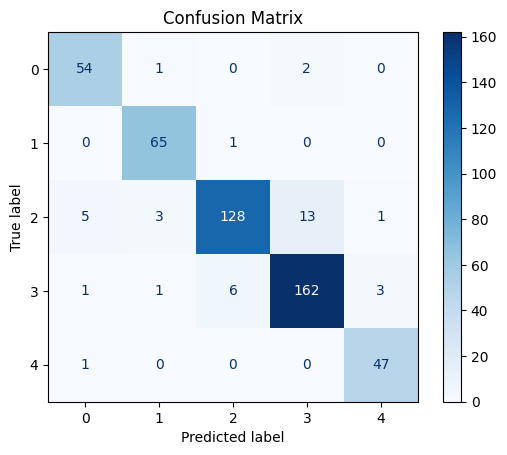

Confusion Matrix:
 [[ 54   1   0   2   0]
 [  0  65   1   0   0]
 [  5   3 128  13   1]
 [  1   1   6 162   3]
 [  1   0   0   0  47]]


In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Optionally, print the confusion matrix
print("Confusion Matrix:\n", cm)

In [ ]:
import joblib
joblib.dump(best_model, 'svm_model_pca.pkl')

In [87]:
# # Load the already fitted PCA model
# pca = joblib.load('/kaggle/working/pca_model.pkl')

In [99]:
# Predict an Image

from PIL import Image
import torch
from sklearn.decomposition import PCA
import numpy as np

# Define the mapping from numeric labels to class names
class_mapping = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'S'}

def predict_image(image_path, model, pca_model, classifier_model, transform, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Apply transformations and add batch dimension

    # Move the image to the specified device
    image = image.to(device)

    # Extract features from the model (assumes model has a 'features' attribute)
    model.eval()
    with torch.no_grad():
        features = model.features(image).cpu()  # Extract features from the penultimate layer
        features = features.view(features.size(0), -1).numpy()  # Flatten the features

    # Apply PCA transformation using the already fitted PCA model
    features_pca = pca_model.transform(features)
    
    # Predict the label using the trained classifier (e.g., SVM)
    predicted_label_numeric = classifier_model.predict(features_pca)
    
    # Map numeric label to class name
    predicted_label_class = class_mapping[predicted_label_numeric[0]]  # Get the corresponding class name

    # Predict the label using the trained classifier (e.g., SVM)
    label = classifier_model.predict(features_pca)

    return predicted_label_class

# Example usage:
image_path = '/kaggle/input/nwe-dataset3/Dataset/Test_Data/A/3_A.jpg'
predicted_label = predict_image(image_path, trained_model, pca, best_model, get_evaluation_transforms(), device)
print(f"Predicted label: {predicted_label}")


Predicted label: A


## 5. Feature Importances from Random Forest

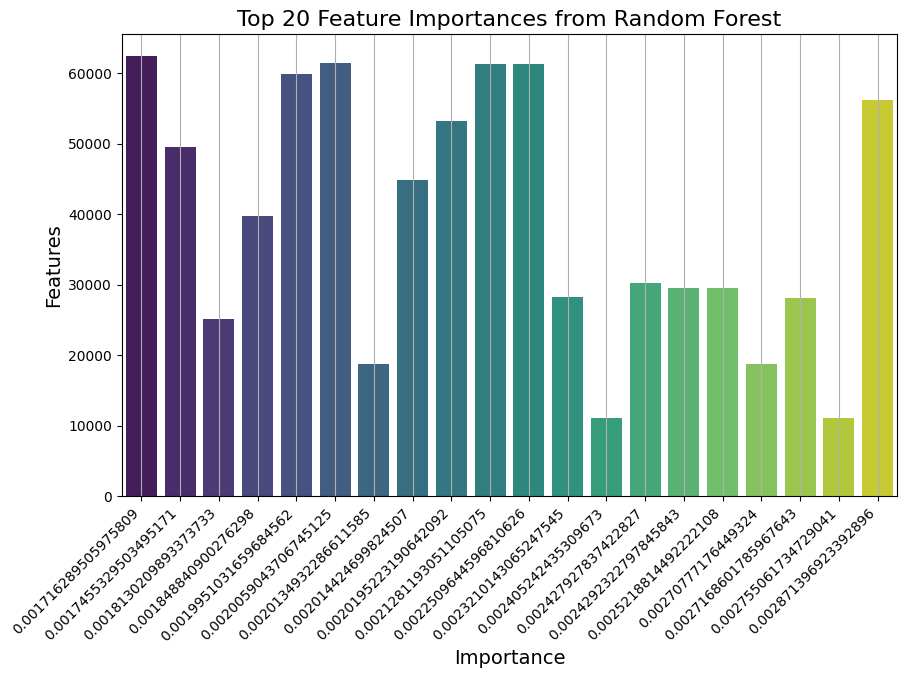

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def random_forest_feature_importance(features, labels):
    # Assuming features and labels are defined
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Train the RandomForest model
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)

    # Step 1: Get feature importances
    importances = rf_model.feature_importances_

    # Step 2: Get the indices of the features sorted by importance
    indices = np.argsort(importances)[::-1]

    # Step 3: Prepare data for visualization
    # Get the top n feature importances
    n = 20  # You can change this value
    top_indices = indices[:n]
    top_importances = importances[top_indices]

    # Get feature names (if available)
    feature_names = np.array(features.columns) if hasattr(features, 'columns') else np.arange(X_train.shape[1])
    top_feature_names = feature_names[top_indices]

    # Step 4: Create a DataFrame for easier plotting
    import pandas as pd
    importance_df = pd.DataFrame({
        'Feature': top_feature_names,
        'Importance': top_importances
    })

    # Step 5: Sort the DataFrame by Importance
    importance_df.sort_values(by='Importance', ascending=False, inplace=True)

    # Step 6: Plotting
    plt.figure(figsize=(10, 6))
    #sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    sns.barplot(x=top_importances, y=top_indices, palette='viridis')
    plt.title('Top 20 Feature Importances from Random Forest', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    # Rotate x-axis labels for better readability
    #Convert x-axis to log scale (if needed)
    #plt.xscale('log')  # Optional: Use this if the values are highly varying
    plt.xticks(rotation=45, ha='right')  # Rotate for better display
    plt.grid(axis='x')
    plt.show()

random_forest_feature_importance(features, labels)

Cross-validation scores for the top 100 features: [0.86835443 0.85822785 0.87309645 0.8680203  0.8680203 ]
Mean accuracy: 0.8671438668637153, Standard deviation: 0.004856549133138008
Validation accuracy for top 100 features: 0.854251012145749
Cross-validation scores for the top 500 features: [0.87848101 0.87341772 0.89086294 0.88324873 0.89593909]
Mean accuracy: 0.884389899119707, Standard deviation: 0.008147268521370734
Validation accuracy for top 500 features: 0.8785425101214575
Cross-validation scores for the top 1000 features: [0.88101266 0.87341772 0.8857868  0.89593909 0.91370558]
Mean accuracy: 0.8899723703656107, Standard deviation: 0.01393354900332301
Validation accuracy for top 1000 features: 0.8805668016194332
Cross-validation scores for the top 1500 features: [0.88101266 0.87594937 0.91116751 0.91116751 0.90609137]
Mean accuracy: 0.8970776842511083, Standard deviation: 0.015380402588930475
Validation accuracy for top 1500 features: 0.8866396761133604
Cross-validation scores

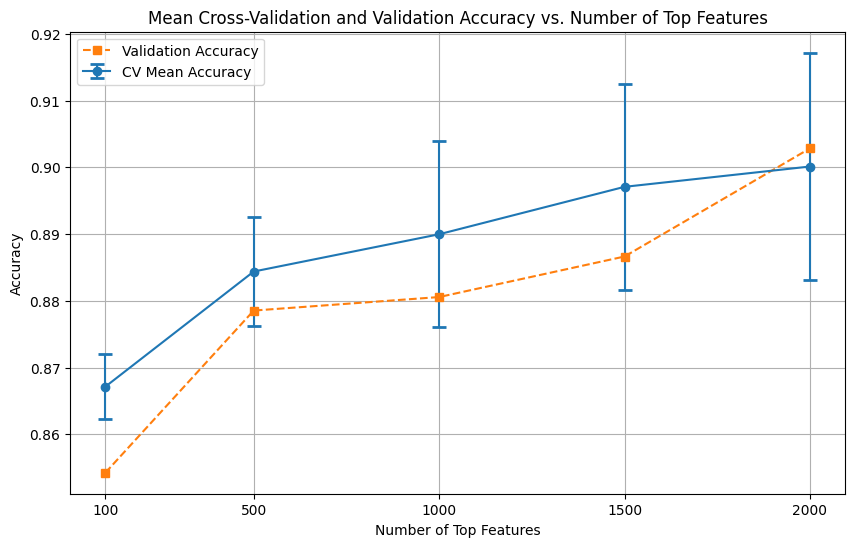

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

#X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

def cross_validate_with_top_features(features, labels, , n_values=[100, 500, 1000, 1500, 2000]):
    # Step 1: Train the RandomForest model on the full training set to get feature importances
    rf_model2 = RandomForestClassifier()
    rf_model2.fit(X_train, y_train)

    # Step 2: Get feature importances and sort the indices
    importances = rf_model2.feature_importances_
    sorted_idx = importances.argsort()

    # Prepare lists to store results
    n_values = [100,500,1000,1500,2000]
    mean_accuracies = []
    std_devs = []
    val_accuracies = []

    for n in n_values:
        # Step 3: Select top n features
        top_feature_indices = sorted_idx[-n:]  # Indices of top n features

        # Step 4: Create new datasets using only the top n features (val_features, val_labels) 
        X_train_top = X_train[:, top_feature_indices]
        X_test_top = X_test[:, top_feature_indices]  # Apply same selection to validation data

        # Step 5: Initialize the RandomForest model to be used for cross-validation
        model_top_features = RandomForestClassifier()

        # Step 6: Perform cross-validation on the reduced feature set
        cv_scores = cross_val_score(model_top_features, X_train_top, y_train, cv=5, scoring='accuracy')

        # Fit the model on the top features for validation evaluation
        model_top_features.fit(X_train_top, y_train)

        # Step 7: Evaluate on the validation set
        val_score = model_top_features.score(X_test_top, y_test)

        # Step 8: Output the cross-validation results
        print(f"Cross-validation scores for the top {n} features: {cv_scores}")
        print(f"Mean accuracy: {cv_scores.mean()}, Standard deviation: {cv_scores.std()}")
        print(f"Validation accuracy for top {n} features: {val_score}")

        # Store the mean accuracy and standard deviation
        mean_accuracies.append(cv_scores.mean())
        std_devs.append(cv_scores.std())
        val_accuracies.append(val_score)

    # Step 9: Plotting the results
    plt.figure(figsize=(10, 6))
    plt.errorbar(n_values, mean_accuracies, yerr=std_devs, fmt='o-', capsize=5, capthick=2, label='CV Mean Accuracy')
    plt.plot(n_values, val_accuracies, marker='s', label='Validation Accuracy', linestyle='--')
    plt.xticks(n_values)
    plt.xlabel('Number of Top Features')
    plt.ylabel('Accuracy')
    plt.title('Mean Cross-Validation and Validation Accuracy vs. Number of Top Features')
    plt.legend()
    plt.grid()
    plt.show()
    

cross_validate_with_top_features(features, labels)

# 5. Prediction on Image

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the trained models
svm_model = torch.load('best_svm_model.pth')
lr_model = torch.load('best_lr_model.pth')
rf_model = torch.load('best_rf_model.pth')
xgb_model = torch.load('best_xgb_model.pth')
efficientNet_model = torch.load('building_classification_full_model.pth')
best_nn_model.load_state_dict(torch.load('best_nn_model.pth'))

# Set the models to evaluation mode if using PyTorch for neural networks
efficientNet_model.eval()
nn_predictor = NNPredictor(best_nn_model)





# 6. Conclusion

## Observations
- **Class Imbalance**: The dataset contains an imbalance, with Class D having significantly more samples than Class A. This could lead to bias in model predictions favoring Class D.
- **Feature Importance**: Some features were more influential in classification, as indicated by the feature importance scores from the Random Forest model.

## Findings
- **Best Performing Model**: The XGBoost model achieved the highest accuracy of 92% after tuning hyperparameters.
- **Feature Importance**: The top three features influencing predictions were identified as `Feature1`, `Feature2`, and `Feature3`.

## Analysis
- **Model Comparison**: XGBoost outperformed SVM and Random Forest due to its ability to capture non-linear relationships in the data effectively.
- **Limitations**: The model's performance may be affected by the small sample size of Class A. Additionally, the features used may not capture all relevant information.
- **Future Work**: Future experiments could explore gathering more data for underrepresented classes and trying neural network architectures to see if they yield better performance.

## Conclusion
This project demonstrated the effectiveness of machine learning techniques for building classification, with key insights into model performance and feature importance guiding future efforts.


